Import important parameter

In [21]:
inputsize = 25
e = 0.05

Import Package

In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import pyamg
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg
from mpl_toolkits.mplot3d import Axes3D
import xlsxwriter
from scipy.ndimage import convolve

Define function

In [23]:
def Restriction(inputsize):
    inputsize = int(inputsize)
    outputsize = int(inputsize/2)
    OUTPUT = np.zeros([outputsize, inputsize])
    for i in range(outputsize):
            OUTPUT[i][2*i] = 1/4
            OUTPUT[i][1+2*i] = 1/2
            OUTPUT[i][2+2*i] = 1/4
    return OUTPUT

def Poisson(inputsize):
    inputsize = int(inputsize)
    outputsize = int(inputsize/2)
    A1 = 2*np.eye(inputsize)
    for i in range(inputsize-1):
        A1[i, i+1] = -1
        A1[i+1, i] = -1
    OUTPUT = A1
    return OUTPUT

def Multigrid_circle(inputsize, A_A, B, R_A, s, w, error):
    A = np.matrix(A_A)
    P = 2.*np.transpose(R_A)
    R = np.matrix(R_A)
    M = np.matrix(w**(-1)*np.diag(np.diag(A)))
    K = M - A
    C = np.linalg.inv(M)*K
    b = np.linalg.inv(M)*B
    U0 = np.matrix(np.zeros([inputsize, 1]))
    RESIDUAL = []
    Residual=1
    i=0
    while Residual > error:
        for j in range(s):
            U0 = C*U0+b
        r = B - A*U0
        Residual = np.linalg.norm(r,2)
        rc = R*r
        Ac = R*A*P
        Uc = np.linalg.solve(Ac, rc)
        U = U0 + P*Uc
        for k in range(s):
            U = C*U+b
        U0 = U
        RESIDUAL.append(Residual)
        i=i+1
        print("Residual = {}".format(Residual))
        print("Interation = {}".format(i))
        print("===================")
    return U0, RESIDUAL

def rho(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

def optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam):
    rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    device = torch.device('cpu')
    R = torch.tensor(R,dtype = torch.double, requires_grad=True,device=device)
    w = torch.tensor(w,dtype = torch.double, requires_grad=True, device=device)
    lam = torch.tensor(lam,dtype = torch.double, requires_grad=True, device=device)
    A = torch.tensor(A1,dtype = torch.double, device=device)
    P = 2.*torch.t(R)
    M = (w**(-1)) * torch.diag(torch.diag(A))
    K = M - A
    MK = torch.mm(torch.inverse(M),K)
    I = torch.eye(inputsize,dtype = torch.double, device=device)
    I1 = torch.ones([inputsize,1],dtype = torch.double, device=device)
    I2 = torch.ones([outputsize,1],dtype = torch.double, device=device)
    IPRAPRA = I - torch.mm(torch.mm(torch.mm(P,torch.inverse(torch.mm(torch.mm(R,A),P))),R),A)
    C = torch.mm(torch.mm(MK,IPRAPRA),MK)
    for i in range(5):
        C = torch.mm(C,C)
    loss = torch.norm(C)**(1/32) + torch.mm(lam,torch.mm(R,I1) - I2)
    loss.backward()
    with torch.no_grad():
        R-=learning_rate*R.grad
        w-=learning_rate*w.grad 
        lam-=learning_rate*lam.grad
    R = R.detach().numpy()
    w = w.detach().numpy()
    lam = lam.detach().numpy()
    rhonew = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    return R, w, lam, rhoold, rhonew

def direct_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate, lam):
    Rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    Rhonew = [Rhoold]
    for i in range(100):
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        R = Rnew
        w = wnew
        lam = lamnew
        print("rho = {}".format(rhonew))
        print("===================")
        Rhonew.append(rhonew)
        i+=1
    print("======End======")
    return R, w, Rhoold, Rhonew

def homotopy_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate ,accept_radius ,step_length,lam):
    Rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    Radius = [Rhoold]
    L = step_length
    print("======Section 1======")
    while L < 1:
        M = (1-L)*A0 + L*A1
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, M, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        if rhonew > accept_radius:
            step_length = 0.1*step_length
            learning_rate = 0.1*learning_rate
            print('Decrease the step_length, learning_rate and Restart!!')
            print("step_length = {}".format(step_length))      
            print("learning_rate = {}".format(learning_rate))
            print("rhonew = {}".format(rhonew))
            print("===================")
            R = Restriction(inputsize)
            lam = np.zeros([1,outputsize])
            w = 2/3
            L = step_length
        else:
            R = Rnew
            w = wnew
            L += step_length
            lam = lamnew
            print("L = {}".format(L))
            print("rho = {}".format(rhonew))
            print("===================")
    print("======Section 2======")
    i = 0
    while rhoold>rhonew and i <20000:
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        R = Rnew
        w = wnew
        lam = lamnew
        print("the {} steps".format(i))
        print("rho = {}".format(rhonew))
        print("===================")
        i+=1            
    Rhonew = rhonew
    print("======End======")
    return R, w, Rhoold, Rhonew, Radius

Define parameter

In [24]:
s = 1
w = 2/3
MAX_ITER = 50
def u_real(x): return np.sin(4.*np.pi*x)
def rightf(x): return  -4*np.pi**2*np.cos(4*np.pi*x)*np.cos(np.pi*x/e)/e+16*(np.pi**2)*(2+np.sin(np.pi*x/e))*np.sin(4*np.pi*x)
def a(x): return 2+np.sin(np.pi*x/e)
outputsize = int(inputsize/2)
h = 1/(inputsize-1)
X = np.linspace(0, 1, inputsize)
H = 1/(outputsize-1)
Media = a(np.linspace(-h,1+h,inputsize+1))
A0 = Poisson(inputsize)
A1 = gallery.divkrad((inputsize,),Media)
RightF = rightf(X)*h**2
RightF = RightF.reshape(inputsize, 1)
UREAL = u_real(X).reshape(inputsize, 1)
R = Restriction(inputsize)
P = 2.*np.transpose(R)

Local DMM on fine grid

In [5]:
K = 10
batch_size = 10
num_iter = 4000
step_size = 5e-5
PR_stencil_type = "m3p"
init_point = None
convergence = {}
deep_gmm = dgmg.DeepMG(A1, K=K, PR_stencil_type=PR_stencil_type, max_levels=2)
opt_par = deep_gmm.optimize(num_iter=num_iter, step_size=step_size, batch_size=batch_size, init_point=init_point)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Iteration 100/4000
Upper bound estimation = 0.6912709545165384
Iteration 200/4000
Upper bound estimation = 0.6861893135013201
Iteration 300/4000
Upper bound estimation = 0.6882152740291266
Iteration 400/4000
Upper bound estimation = 0.6625368046270191
Iteration 500/4000
Upper bound estimation = 0.6346381899755231
Iteration 600/4000
Upper bound estimation = 0.6310186749853859
Iteration 700/4000
Upper bound estimation = 0.6009892036215376
Iteration 800/4000
Upper bound estimation = 0.5684905597762672
Iteration 900/4000
Upper bound estimation = 0.5492131187060897
Iteration 1000/4000
Upper bound estimation = 0.535804787075733
Iteration 1100/4000
Upper bound estimation = 0.4957244901987304
Iteration 1200/4000
Upper bound estimation = 0.47748369292423515
Iteration 1300/4000
Upper bound estimation = 0.4589354503887438
Iteration 1400/4000
Upper bound estimation = 0.4270222406379222
Iteration 1500/4000
Upper bound estimation = 0.4048827657509706
Iteration 1600/4000
Upper bound estimation = 0.40

In [6]:
deep_gmm.update_prd(opt_par)  
current_rho = deep_gmm.compute_rho()
print("Optimized rho = {}".format(current_rho))

Optimized rho = 0.31971478412833054


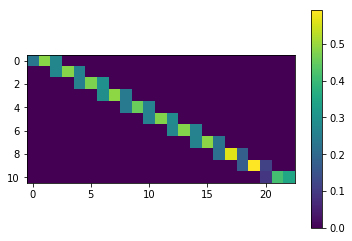

In [7]:
localR = opt_par[1][0]
LOCALR = np.zeros([outputsize-1,inputsize-2])
for i in range(outputsize-1):
    C = localR[i][:]
    for l in range(3):
        LOCALR[i][2*i+l] = C[l]
        
        
plt.imshow(LOCALR)
plt.colorbar()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


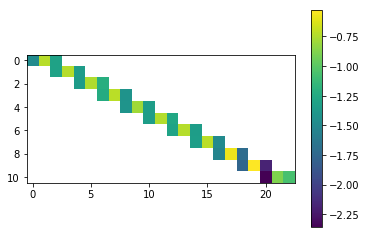

In [8]:
plt.imshow(np.log(np.abs(LOCALR)))
plt.colorbar()

In [9]:
Rnew, wnew, Rhoold, Rhonew, Radius = homotopy_optimizer_GD(inputsize, A0, A1.to_full(), R,  2/3, s, learning_rate = 1e-6,accept_radius = 1 ,step_length = 1e-2, lam = np.zeros([1,outputsize]))

======Section 1======
L = 0.02
rho = 0.11806195968467219
L = 0.03
rho = 0.11886814863153873
L = 0.04
rho = 0.11995148982198496
L = 0.05
rho = 0.12117628402035288
L = 0.060000000000000005
rho = 0.12247873543265196
L = 0.07
rho = 0.12383058417265687
L = 0.08
rho = 0.1252190628892217
L = 0.09
rho = 0.12663837192510732
L = 0.09999999999999999
rho = 0.12808611169679232
L = 0.10999999999999999
rho = 0.12956168983047625
L = 0.11999999999999998
rho = 0.1310655416452155
L = 0.12999999999999998
rho = 0.1325987071759763
L = 0.13999999999999999
rho = 0.1341625742299984
L = 0.15
rho = 0.13575870308551047
L = 0.16
rho = 0.1373886941229856
L = 0.17
rho = 0.1390540809059687
L = 0.18000000000000002
rho = 0.14075624165358247
L = 0.19000000000000003
rho = 0.1424963271859733
L = 0.20000000000000004
rho = 0.1442752056732396
L = 0.21000000000000005
rho = 0.14609342504633274
L = 0.22000000000000006
rho = 0.14795119342655116
L = 0.23000000000000007
rho = 0.14984837690241368
L = 0.24000000000000007
rho = 0.151

the 83 steps
rho = 0.3287019602471712
the 84 steps
rho = 0.32868654329480296
the 85 steps
rho = 0.3286711603231227
the 86 steps
rho = 0.32865581111781106
the 87 steps
rho = 0.32864049546563623
the 88 steps
rho = 0.32862521315444704
the 89 steps
rho = 0.32860996397317427
the 90 steps
rho = 0.32859474771183655
the 91 steps
rho = 0.32857956416153217
the 92 steps
rho = 0.3285644131144471
the 93 steps
rho = 0.3285492943638488
the 94 steps
rho = 0.32853420770408986
the 95 steps
rho = 0.32851915293060785
the 96 steps
rho = 0.3285041298399226
the 97 steps
rho = 0.3284891382296367
the 98 steps
rho = 0.32847417789843875
the 99 steps
rho = 0.32845924864609416
the 100 steps
rho = 0.3284443502734542
the 101 steps
rho = 0.32842948258244964
the 102 steps
rho = 0.32841464537608933
the 103 steps
rho = 0.3283998384584624
the 104 steps
rho = 0.32838506163473585
the 105 steps
rho = 0.32837031471115463
the 106 steps
rho = 0.32835559749503357
the 107 steps
rho = 0.32834090979476604
the 108 steps
rho = 0.328

the 269 steps
rho = 0.32624202568269
the 270 steps
rho = 0.3262302843459445
the 271 steps
rho = 0.32621855319592985
the 272 steps
rho = 0.3262068321705895
the 273 steps
rho = 0.3261951212083286
the 274 steps
rho = 0.32618342024801733
the 275 steps
rho = 0.3261717292289808
the 276 steps
rho = 0.32616004809099997
the 277 steps
rho = 0.32614837677431163
the 278 steps
rho = 0.3261367152195983
the 279 steps
rho = 0.3261250633679887
the 280 steps
rho = 0.3261134211610535
the 281 steps
rho = 0.32610178854080357
the 282 steps
rho = 0.32609016544968783
the 283 steps
rho = 0.32607855183058526
the 284 steps
rho = 0.3260669476268059
the 285 steps
rho = 0.326055352782088
the 286 steps
rho = 0.3260437672405944
the 287 steps
rho = 0.32603219094690494
the 288 steps
rho = 0.3260206238460214
the 289 steps
rho = 0.3260090658833603
the 290 steps
rho = 0.3259975170047471
the 291 steps
rho = 0.32598597715641914
the 292 steps
rho = 0.3259744462850169
the 293 steps
rho = 0.32596292433758806
the 294 steps
rho 

the 435 steps
rho = 0.32439742365662066
the 436 steps
rho = 0.3243867886734094
the 437 steps
rho = 0.3243761580060494
the 438 steps
rho = 0.3243655316370427
the 439 steps
rho = 0.32435490954901897
the 440 steps
rho = 0.32434429172474033
the 441 steps
rho = 0.32433367814709974
the 442 steps
rho = 0.32432306879911815
the 443 steps
rho = 0.3243124636639484
the 444 steps
rho = 0.32430186272486317
the 445 steps
rho = 0.3242912659652703
the 446 steps
rho = 0.3242806733686965
the 447 steps
rho = 0.32427008491879383
the 448 steps
rho = 0.3242595005993403
the 449 steps
rho = 0.32424892039423514
the 450 steps
rho = 0.3242383442874969
the 451 steps
rho = 0.3242277722632657
the 452 steps
rho = 0.32421720430580414
the 453 steps
rho = 0.32420664039948754
the 454 steps
rho = 0.3241960805288164
the 455 steps
rho = 0.3241855246783999
the 456 steps
rho = 0.32417497283296887
the 457 steps
rho = 0.3241644249773663
the 458 steps
rho = 0.3241538810965514
the 459 steps
rho = 0.32414334117559346
the 460 steps

the 592 steps
rho = 0.32277209489555364
the 593 steps
rho = 0.3227619867938319
the 594 steps
rho = 0.3227518813861662
the 595 steps
rho = 0.32274177866708914
the 596 steps
rho = 0.32273167863117036
the 597 steps
rho = 0.3227215812730219
the 598 steps
rho = 0.3227114865872888
the 599 steps
rho = 0.32270139456866115
the 600 steps
rho = 0.3226913052118609
the 601 steps
rho = 0.32268121851165077
the 602 steps
rho = 0.3226711344628303
the 603 steps
rho = 0.3226610530602372
the 604 steps
rho = 0.32265097429874406
the 605 steps
rho = 0.322640898173262
the 606 steps
rho = 0.32263082467873755
the 607 steps
rho = 0.3226207538101525
the 608 steps
rho = 0.3226106855625258
the 609 steps
rho = 0.32260061993091166
the 610 steps
rho = 0.32259055691039734
the 611 steps
rho = 0.32258049649610976
the 612 steps
rho = 0.32257043868320395
the 613 steps
rho = 0.32256038346687593
the 614 steps
rho = 0.32255033084235124
the 615 steps
rho = 0.3225402808048911
the 616 steps
rho = 0.3225302333497909
the 617 steps

the 764 steps
rho = 0.32106965469619125
the 765 steps
rho = 0.32105995396760784
the 766 steps
rho = 0.3210502553848674
the 767 steps
rho = 0.32104055894629774
the 768 steps
rho = 0.32103086465023495
the 769 steps
rho = 0.32102117249502804
the 770 steps
rho = 0.3210114824790356
the 771 steps
rho = 0.3210017946006289
the 772 steps
rho = 0.3209921088581872
the 773 steps
rho = 0.3209824252501016
the 774 steps
rho = 0.3209727437747751
the 775 steps
rho = 0.3209630644306176
the 776 steps
rho = 0.3209533872160528
the 777 steps
rho = 0.32094371212951256
the 778 steps
rho = 0.3209340391694377
the 779 steps
rho = 0.3209243683342839
the 780 steps
rho = 0.32091469962251173
the 781 steps
rho = 0.32090503303259454
the 782 steps
rho = 0.3208953685630151
the 783 steps
rho = 0.3208857062122656
the 784 steps
rho = 0.32087604597884817
the 785 steps
rho = 0.3208663878612726
the 786 steps
rho = 0.3208567318580636
the 787 steps
rho = 0.3208470779677496
the 788 steps
rho = 0.3208374261888716
the 789 steps
rh

the 918 steps
rho = 0.3196002255019212
the 919 steps
rho = 0.3195908406079445
the 920 steps
rho = 0.31958145769479046
the 921 steps
rho = 0.31957207676181637
the 922 steps
rho = 0.3195626978083828
the 923 steps
rho = 0.31955332083385296
the 924 steps
rho = 0.31954394583759266
the 925 steps
rho = 0.3195345728189755
the 926 steps
rho = 0.31952520177737437
the 927 steps
rho = 0.3195158327121706
the 928 steps
rho = 0.3195064656227431
the 929 steps
rho = 0.31949710050847946
the 930 steps
rho = 0.3194877373687679
the 931 steps
rho = 0.3194783762030016
the 932 steps
rho = 0.319469017010578
the 933 steps
rho = 0.3194596597908951
the 934 steps
rho = 0.3194503045433569
the 935 steps
rho = 0.3194409512673692
the 936 steps
rho = 0.3194315999623441
the 937 steps
rho = 0.3194222506276933
the 938 steps
rho = 0.31941290326283495
the 939 steps
rho = 0.3194035578671877
the 940 steps
rho = 0.31939421444017707
the 941 steps
rho = 0.31938487298122714
the 942 steps
rho = 0.3193755334897712
the 943 steps
rho

the 1100 steps
rho = 0.31792429867540434
the 1101 steps
rho = 0.3179152665301999
the 1102 steps
rho = 0.3179062362921696
the 1103 steps
rho = 0.31789720796107535
the 1104 steps
rho = 0.31788818153667864
the 1105 steps
rho = 0.3178791570187442
the 1106 steps
rho = 0.3178701344070373
the 1107 steps
rho = 0.31786111370132464
the 1108 steps
rho = 0.3178520949013744
the 1109 steps
rho = 0.317843078006954
the 1110 steps
rho = 0.31783406301783507
the 1111 steps
rho = 0.3178250499337885
the 1112 steps
rho = 0.31781603875458697
the 1113 steps
rho = 0.3178070294800035
the 1114 steps
rho = 0.31779802210981245
the 1115 steps
rho = 0.317789016643792
the 1116 steps
rho = 0.3177800130817175
the 1117 steps
rho = 0.31777101142336733
the 1118 steps
rho = 0.3177620116685207
the 1119 steps
rho = 0.3177530138169577
the 1120 steps
rho = 0.3177440178684617
the 1121 steps
rho = 0.3177350238228143
the 1122 steps
rho = 0.31772603167979835
the 1123 steps
rho = 0.31771704143920065
the 1124 steps
rho = 0.317708053

the 1270 steps
rho = 0.31641607358694473
the 1271 steps
rho = 0.31640736303790085
the 1272 steps
rho = 0.31639865436890635
the 1273 steps
rho = 0.31638994757986333
the 1274 steps
rho = 0.31638124267067236
the 1275 steps
rho = 0.3163725396412357
the 1276 steps
rho = 0.31636383849145777
the 1277 steps
rho = 0.31635513922124
the 1278 steps
rho = 0.3163464418304877
the 1279 steps
rho = 0.31633774631910255
the 1280 steps
rho = 0.31632905268699346
the 1281 steps
rho = 0.31632036093406285
the 1282 steps
rho = 0.31631167106021807
the 1283 steps
rho = 0.31630298306536514
the 1284 steps
rho = 0.3162942969494119
the 1285 steps
rho = 0.31628561271226513
the 1286 steps
rho = 0.31627693035383275
the 1287 steps
rho = 0.31626824987402385
the 1288 steps
rho = 0.316259571272747
the 1289 steps
rho = 0.3162508945499132
the 1290 steps
rho = 0.3162422197054318
the 1291 steps
rho = 0.3162335467392122
the 1292 steps
rho = 0.3162248756511681
the 1293 steps
rho = 0.3162162064412088
the 1294 steps
rho = 0.316207

the 1451 steps
rho = 0.31487001506641327
the 1452 steps
rho = 0.31486164365370384
the 1453 steps
rho = 0.3148532741104955
the 1454 steps
rho = 0.3148449064367651
the 1455 steps
rho = 0.31483654063248756
the 1456 steps
rho = 0.3148281766976424
the 1457 steps
rho = 0.3148198146322061
the 1458 steps
rho = 0.3148114544361545
the 1459 steps
rho = 0.3148030961094683
the 1460 steps
rho = 0.3147947396521232
the 1461 steps
rho = 0.3147863850640986
the 1462 steps
rho = 0.3147780323453754
the 1463 steps
rho = 0.3147696814959302
the 1464 steps
rho = 0.31476133251574395
the 1465 steps
rho = 0.3147529854047953
the 1466 steps
rho = 0.31474464016306686
the 1467 steps
rho = 0.3147362967905367
the 1468 steps
rho = 0.3147279552871875
the 1469 steps
rho = 0.31471961565299855
the 1470 steps
rho = 0.3147112778879531
the 1471 steps
rho = 0.314702941992032
the 1472 steps
rho = 0.3146946079652181
the 1473 steps
rho = 0.3146862758074932
the 1474 steps
rho = 0.3146779455188403
the 1475 steps
rho = 0.314669617099

the 1627 steps
rho = 0.31342542761986925
the 1628 steps
rho = 0.3134173851494203
the 1629 steps
rho = 0.3134093445489544
the 1630 steps
rho = 0.31340130581849734
the 1631 steps
rho = 0.31339326895807834
the 1632 steps
rho = 0.31338523396772605
the 1633 steps
rho = 0.31337720084746956
the 1634 steps
rho = 0.31336916959733463
the 1635 steps
rho = 0.313361140217352
the 1636 steps
rho = 0.3133531127075512
the 1637 steps
rho = 0.31334508706796144
the 1638 steps
rho = 0.3133370632986121
the 1639 steps
rho = 0.3133290413995343
the 1640 steps
rho = 0.31332102137075724
the 1641 steps
rho = 0.3133130032123115
the 1642 steps
rho = 0.3133049869242285
the 1643 steps
rho = 0.3132969725065379
the 1644 steps
rho = 0.31328895995927264
the 1645 steps
rho = 0.3132809492824652
the 1646 steps
rho = 0.31327294047614457
the 1647 steps
rho = 0.3132649335403454
the 1648 steps
rho = 0.3132569284750978
the 1649 steps
rho = 0.3132489252804362
the 1650 steps
rho = 0.31324092395639347
the 1651 steps
rho = 0.3132329

the 1803 steps
rho = 0.3120387852520254
the 1804 steps
rho = 0.31203107255430207
the 1805 steps
rho = 0.3120233617353544
the 1806 steps
rho = 0.3120156527952553
the 1807 steps
rho = 0.3120079457340774
the 1808 steps
rho = 0.3120002405518911
the 1809 steps
rho = 0.31199253724877074
the 1810 steps
rho = 0.3119848358247876
the 1811 steps
rho = 0.3119771362800145
the 1812 steps
rho = 0.31196943861452603
the 1813 steps
rho = 0.3119617428283934
the 1814 steps
rho = 0.31195404892169254
the 1815 steps
rho = 0.3119463568944953
the 1816 steps
rho = 0.3119386667468766
the 1817 steps
rho = 0.3119309784789104
the 1818 steps
rho = 0.3119232920906717
the 1819 steps
rho = 0.31191560758223386
the 1820 steps
rho = 0.3119079249536743
the 1821 steps
rho = 0.31190024420506574
the 1822 steps
rho = 0.31189256533648524
the 1823 steps
rho = 0.3118848883480074
the 1824 steps
rho = 0.31187721323970924
the 1825 steps
rho = 0.31186954001166617
the 1826 steps
rho = 0.3118618686639549
the 1827 steps
rho = 0.31185419

the 1951 steps
rho = 0.3109177857051099
the 1952 steps
rho = 0.3109103519676531
the 1953 steps
rho = 0.3109029201220519
the 1954 steps
rho = 0.31089549016841356
the 1955 steps
rho = 0.3108880621068394
the 1956 steps
rho = 0.31088063593743664
the 1957 steps
rho = 0.31087321166031034
the 1958 steps
rho = 0.31086578927556485
the 1959 steps
rho = 0.3108583687833071
the 1960 steps
rho = 0.31085095018364095
the 1961 steps
rho = 0.3108435334766741
the 1962 steps
rho = 0.31083611866251154
the 1963 steps
rho = 0.3108287057412604
the 1964 steps
rho = 0.3108212947130272
the 1965 steps
rho = 0.3108138855779182
the 1966 steps
rho = 0.3108064783360413
the 1967 steps
rho = 0.3107990729875023
the 1968 steps
rho = 0.31079166953241105
the 1969 steps
rho = 0.31078426797087294
the 1970 steps
rho = 0.310776868302997
the 1971 steps
rho = 0.31076947052888926
the 1972 steps
rho = 0.31076207464866074
the 1973 steps
rho = 0.3107546806624175
the 1974 steps
rho = 0.31074728857026984
the 1975 steps
rho = 0.3107398

the 2119 steps
rho = 0.3096955442301168
the 2120 steps
rho = 0.3096884299419726
the 2121 steps
rho = 0.3096813175659139
the 2122 steps
rho = 0.3096742071020738
the 2123 steps
rho = 0.3096670985505888
the 2124 steps
rho = 0.3096599919115933
the 2125 steps
rho = 0.3096528871852224
the 2126 steps
rho = 0.3096457843716128
the 2127 steps
rho = 0.3096386834709005
the 2128 steps
rho = 0.30963158448321726
the 2129 steps
rho = 0.3096244874087048
the 2130 steps
rho = 0.30961739224749485
the 2131 steps
rho = 0.309610298999726
the 2132 steps
rho = 0.3096032076655342
the 2133 steps
rho = 0.309596118245054
the 2134 steps
rho = 0.30958903073842536
the 2135 steps
rho = 0.30958194514578247
the 2136 steps
rho = 0.3095748614672634
the 2137 steps
rho = 0.3095677797030054
the 2138 steps
rho = 0.309560699853145
the 2139 steps
rho = 0.3095536219178198
the 2140 steps
rho = 0.3095465458971681
the 2141 steps
rho = 0.30953947179132757
the 2142 steps
rho = 0.309532399600436
the 2143 steps
rho = 0.3095253293246287

the 2298 steps
rho = 0.3084526804345413
the 2299 steps
rho = 0.3084459106810266
the 2300 steps
rho = 0.30843914286569835
the 2301 steps
rho = 0.30843237698871045
the 2302 steps
rho = 0.3084256130502169
the 2303 steps
rho = 0.3084188510503736
the 2304 steps
rho = 0.3084120909893324
the 2305 steps
rho = 0.3084053328672487
the 2306 steps
rho = 0.3083985766842773
the 2307 steps
rho = 0.3083918224405716
the 2308 steps
rho = 0.30838507013628635
the 2309 steps
rho = 0.3083783197715771
the 2310 steps
rho = 0.30837157134659493
the 2311 steps
rho = 0.3083648248614994
the 2312 steps
rho = 0.308358080316442
the 2313 steps
rho = 0.3083513377115779
the 2314 steps
rho = 0.3083445970470627
the 2315 steps
rho = 0.30833785832304994
the 2316 steps
rho = 0.3083311215396953
the 2317 steps
rho = 0.3083243866971535
the 2318 steps
rho = 0.30831765379557935
the 2319 steps
rho = 0.3083109228351277
the 2320 steps
rho = 0.3083041938159535
the 2321 steps
rho = 0.30829746673821223
the 2322 steps
rho = 0.30829074160

the 2477 steps
rho = 0.30727191797326386
the 2478 steps
rho = 0.3072654976344596
the 2479 steps
rho = 0.3072590792616702
the 2480 steps
rho = 0.30725266285504815
the 2481 steps
rho = 0.3072462484147453
the 2482 steps
rho = 0.3072398359409148
the 2483 steps
rho = 0.30723342543371057
the 2484 steps
rho = 0.3072270168932849
the 2485 steps
rho = 0.30722061031978826
the 2486 steps
rho = 0.3072142057133744
the 2487 steps
rho = 0.30720780307419593
the 2488 steps
rho = 0.30720140240240446
the 2489 steps
rho = 0.3071950036981525
the 2490 steps
rho = 0.3071886069615928
the 2491 steps
rho = 0.3071822121928755
the 2492 steps
rho = 0.3071758193921539
the 2493 steps
rho = 0.3071694285595796
the 2494 steps
rho = 0.30716303969530423
the 2495 steps
rho = 0.30715665279947985
the 2496 steps
rho = 0.3071502678722573
the 2497 steps
rho = 0.3071438849137882
the 2498 steps
rho = 0.30713750392422473
the 2499 steps
rho = 0.30713112490371647
the 2500 steps
rho = 0.30712474785241495
the 2501 steps
rho = 0.307118

the 2641 steps
rho = 0.30624536744297676
the 2642 steps
rho = 0.306239271492575
the 2643 steps
rho = 0.3062331775315858
the 2644 steps
rho = 0.3062270855601354
the 2645 steps
rho = 0.3062209955783538
the 2646 steps
rho = 0.30621490758636727
the 2647 steps
rho = 0.3062088215843033
the 2648 steps
rho = 0.3062027375722896
the 2649 steps
rho = 0.30619665555045233
the 2650 steps
rho = 0.30619057551891926
the 2651 steps
rho = 0.3061844974778169
the 2652 steps
rho = 0.3061784214272703
the 2653 steps
rho = 0.3061723473674071
the 2654 steps
rho = 0.3061662752983511
the 2655 steps
rho = 0.3061602052202285
the 2656 steps
rho = 0.3061541371331661
the 2657 steps
rho = 0.30614807103728797
the 2658 steps
rho = 0.3061420069327175
the 2659 steps
rho = 0.3061359448195823
the 2660 steps
rho = 0.30612988469800323
the 2661 steps
rho = 0.30612382656810605
the 2662 steps
rho = 0.30611777043001615
the 2663 steps
rho = 0.3061117162838541
the 2664 steps
rho = 0.30610566412974516
the 2665 steps
rho = 0.306099613

the 2785 steps
rho = 0.3053880915645707
the 2786 steps
rho = 0.30538228327892086
the 2787 steps
rho = 0.30537647699826515
the 2788 steps
rho = 0.30537067272268537
the 2789 steps
rho = 0.3053648704522681
the 2790 steps
rho = 0.3053590701870952
the 2791 steps
rho = 0.3053532719272505
the 2792 steps
rho = 0.30534747567281784
the 2793 steps
rho = 0.3053416814238786
the 2794 steps
rho = 0.30533588918051546
the 2795 steps
rho = 0.3053300989428093
the 2796 steps
rho = 0.30532431071084143
the 2797 steps
rho = 0.30531852448469415
the 2798 steps
rho = 0.30531274026444744
the 2799 steps
rho = 0.3053069580501805
the 2800 steps
rho = 0.3053011778419736
the 2801 steps
rho = 0.3052953996399071
the 2802 steps
rho = 0.30528962344405886
the 2803 steps
rho = 0.30528384925450747
the 2804 steps
rho = 0.30527807707133203
the 2805 steps
rho = 0.30527230689460944
the 2806 steps
rho = 0.30526653872441745
the 2807 steps
rho = 0.30526077256083245
the 2808 steps
rho = 0.3052550084039319
the 2809 steps
rho = 0.305

the 2929 steps
rho = 0.3045723759355944
the 2930 steps
rho = 0.3045668570346338
the 2931 steps
rho = 0.30456134014639463
the 2932 steps
rho = 0.3045558252708958
the 2933 steps
rho = 0.30455031240815533
the 2934 steps
rho = 0.30454480155819136
the 2935 steps
rho = 0.30453929272102065
the 2936 steps
rho = 0.30453378589666114
the 2937 steps
rho = 0.30452828108512775
the 2938 steps
rho = 0.304522778286437
the 2939 steps
rho = 0.3045172775006036
the 2940 steps
rho = 0.30451177872764174
the 2941 steps
rho = 0.3045062819675671
the 2942 steps
rho = 0.3045007872203912
the 2943 steps
rho = 0.3044952944861278
the 2944 steps
rho = 0.30448980376478973
the 2945 steps
rho = 0.30448431505638907
the 2946 steps
rho = 0.30447882836093604
the 2947 steps
rho = 0.30447334367844237
the 2948 steps
rho = 0.30446786100891776
the 2949 steps
rho = 0.30446238035237244
the 2950 steps
rho = 0.3044569017088158
the 2951 steps
rho = 0.30445142507825496
the 2952 steps
rho = 0.30444595046070033
the 2953 steps
rho = 0.304

the 3069 steps
rho = 0.30381931348129304
the 3070 steps
rho = 0.30381407629237944
the 3071 steps
rho = 0.3038088411132289
the 3072 steps
rho = 0.3038036079437764
the 3073 steps
rho = 0.303798376783957
the 3074 steps
rho = 0.3037931476337031
the 3075 steps
rho = 0.30378792049294884
the 3076 steps
rho = 0.30378269536162666
the 3077 steps
rho = 0.30377747223966883
the 3078 steps
rho = 0.3037722511270056
the 3079 steps
rho = 0.3037670320235683
the 3080 steps
rho = 0.30376181492928606
the 3081 steps
rho = 0.303756599844089
the 3082 steps
rho = 0.3037513867679049
the 3083 steps
rho = 0.30374617570066215
the 3084 steps
rho = 0.3037409666422866
the 3085 steps
rho = 0.30373575959270627
the 3086 steps
rho = 0.3037305545518466
the 3087 steps
rho = 0.3037253515196333
the 3088 steps
rho = 0.30372015049598816
the 3089 steps
rho = 0.3037149514808381
the 3090 steps
rho = 0.30370975447410525
the 3091 steps
rho = 0.3037045594757109
the 3092 steps
rho = 0.30369936648557905
the 3093 steps
rho = 0.30369417

the 3214 steps
rho = 0.3030808586405348
the 3215 steps
rho = 0.3030759118464454
the 3216 steps
rho = 0.30307096704540604
the 3217 steps
rho = 0.3030660242372481
the 3218 steps
rho = 0.3030610834218015
the 3219 steps
rho = 0.3030561445988959
the 3220 steps
rho = 0.30305120776836053
the 3221 steps
rho = 0.30304627293002134
the 3222 steps
rho = 0.3030413400837092
the 3223 steps
rho = 0.303036409229247
the 3224 steps
rho = 0.30303148036646266
the 3225 steps
rho = 0.3030265534951788
the 3226 steps
rho = 0.30302162861522197
the 3227 steps
rho = 0.30301670572641465
the 3228 steps
rho = 0.3030117848285789
the 3229 steps
rho = 0.30300686592153636
the 3230 steps
rho = 0.3030019490051093
the 3231 steps
rho = 0.3029970340791169
the 3232 steps
rho = 0.30299212114337837
the 3233 steps
rho = 0.30298721019771263
the 3234 steps
rho = 0.302982301241939
the 3235 steps
rho = 0.30297739427587306
the 3236 steps
rho = 0.3029724892993317
the 3237 steps
rho = 0.3029675863121293
the 3238 steps
rho = 0.302962685

the 3383 steps
rho = 0.30227298453326884
the 3384 steps
rho = 0.3022683715432294
the 3385 steps
rho = 0.3022637605064138
the 3386 steps
rho = 0.3022591514225162
the 3387 steps
rho = 0.30225454429123355
the 3388 steps
rho = 0.3022499391122581
the 3389 steps
rho = 0.30224533588528185
the 3390 steps
rho = 0.3022407346099964
the 3391 steps
rho = 0.30223613528609394
the 3392 steps
rho = 0.30223153791326374
the 3393 steps
rho = 0.302226942491196
the 3394 steps
rho = 0.3022223490195775
the 3395 steps
rho = 0.302217757498097
the 3396 steps
rho = 0.302213167926442
the 3397 steps
rho = 0.30220858030429754
the 3398 steps
rho = 0.3022039946313484
the 3399 steps
rho = 0.30219941090727975
the 3400 steps
rho = 0.3021948291317745
the 3401 steps
rho = 0.3021902493045161
the 3402 steps
rho = 0.3021856714251854
the 3403 steps
rho = 0.3021810954934637
the 3404 steps
rho = 0.3021765215090324
the 3405 steps
rho = 0.3021719494715685
the 3406 steps
rho = 0.30216737938075233
the 3407 steps
rho = 0.302162811236

the 3546 steps
rho = 0.30154661599600846
the 3547 steps
rho = 0.30154231676753307
the 3548 steps
rho = 0.30153801943163006
the 3549 steps
rho = 0.3015337239878574
the 3550 steps
rho = 0.301529430435776
the 3551 steps
rho = 0.3015251387749443
the 3552 steps
rho = 0.3015208490049198
the 3553 steps
rho = 0.3015165611252604
the 3554 steps
rho = 0.30151227513552054
the 3555 steps
rho = 0.3015079910352578
the 3556 steps
rho = 0.30150370882402633
the 3557 steps
rho = 0.30149942850137895
the 3558 steps
rho = 0.3014951500668688
the 3559 steps
rho = 0.30149087352004883
the 3560 steps
rho = 0.30148659886047013
the 3561 steps
rho = 0.3014823260876836
the 3562 steps
rho = 0.30147805520123905
the 3563 steps
rho = 0.30147378620068355
the 3564 steps
rho = 0.30146951908556824
the 3565 steps
rho = 0.3014652538554392
the 3566 steps
rho = 0.30146099050984215
the 3567 steps
rho = 0.30145672904832366
the 3568 steps
rho = 0.3014524694704284
the 3569 steps
rho = 0.3014482117757011
the 3570 steps
rho = 0.30144

the 3711 steps
rho = 0.3008625027766847
the 3712 steps
rho = 0.300858509289317
the 3713 steps
rho = 0.30085451761131815
the 3714 steps
rho = 0.30085052774212273
the 3715 steps
rho = 0.3008465396811621
the 3716 steps
rho = 0.3008425534278669
the 3717 steps
rho = 0.3008385689816698
the 3718 steps
rho = 0.3008345863419988
the 3719 steps
rho = 0.3008306055082846
the 3720 steps
rho = 0.3008266264799563
the 3721 steps
rho = 0.300822649256441
the 3722 steps
rho = 0.3008186738371654
the 3723 steps
rho = 0.30081470022155704
the 3724 steps
rho = 0.30081072840904166
the 3725 steps
rho = 0.30080675839904497
the 3726 steps
rho = 0.3008027901909896
the 3727 steps
rho = 0.3007988237843012
the 3728 steps
rho = 0.30079485917840076
the 3729 steps
rho = 0.30079089637271217
the 3730 steps
rho = 0.3007869353666573
the 3731 steps
rho = 0.30078297615965477
the 3732 steps
rho = 0.3007790187511272
the 3733 steps
rho = 0.30077506314049324
the 3734 steps
rho = 0.3007711093271712
the 3735 steps
rho = 0.3007671573

the 3865 steps
rho = 0.3002684678202399
the 3866 steps
rho = 0.3002647458858476
the 3867 steps
rho = 0.3002610256655529
the 3868 steps
rho = 0.30025730715868737
the 3869 steps
rho = 0.3002535903645851
the 3870 steps
rho = 0.30024987528257596
the 3871 steps
rho = 0.30024616191199127
the 3872 steps
rho = 0.3002424502521628
the 3873 steps
rho = 0.300238740302419
the 3874 steps
rho = 0.30023503206208996
the 3875 steps
rho = 0.30023132553050497
the 3876 steps
rho = 0.3002276207069907
the 3877 steps
rho = 0.3002239175908759
the 3878 steps
rho = 0.30022021618148753
the 3879 steps
rho = 0.30021651647815284
the 3880 steps
rho = 0.300212818480196
the 3881 steps
rho = 0.30020912218694357
the 3882 steps
rho = 0.3002054275977197
the 3883 steps
rho = 0.3002017347118505
the 3884 steps
rho = 0.30019804352865753
the 3885 steps
rho = 0.3001943540474646
the 3886 steps
rho = 0.30019066626759566
the 3887 steps
rho = 0.3001869801883708
the 3888 steps
rho = 0.30018329580911207
the 3889 steps
rho = 0.30017961

the 4036 steps
rho = 0.2996563666552879
the 4037 steps
rho = 0.29965292770196267
the 4038 steps
rho = 0.2996494903412221
the 4039 steps
rho = 0.29964605457231747
the 4040 steps
rho = 0.2996426203944993
the 4041 steps
rho = 0.2996391878070183
the 4042 steps
rho = 0.29963575680912524
the 4043 steps
rho = 0.2996323274000686
the 4044 steps
rho = 0.29962889957909944
the 4045 steps
rho = 0.29962547334546547
the 4046 steps
rho = 0.29962204869841597
the 4047 steps
rho = 0.29961862563719976
the 4048 steps
rho = 0.2996152041610638
the 4049 steps
rho = 0.29961178426925655
the 4050 steps
rho = 0.29960836596102425
the 4051 steps
rho = 0.299604949235615
the 4052 steps
rho = 0.2996015340922741
the 4053 steps
rho = 0.29959812053024887
the 4054 steps
rho = 0.2995947085487844
the 4055 steps
rho = 0.29959129814712615
the 4056 steps
rho = 0.2995878893245199
the 4057 steps
rho = 0.29958448208020955
the 4058 steps
rho = 0.29958107641343995
the 4059 steps
rho = 0.29957767232345517
the 4060 steps
rho = 0.2995

the 4196 steps
rho = 0.2991258814234732
the 4197 steps
rho = 0.299122687542669
the 4198 steps
rho = 0.2991194951307418
the 4199 steps
rho = 0.299116304186898
the 4200 steps
rho = 0.2991131147103455
the 4201 steps
rho = 0.2991099267002917
the 4202 steps
rho = 0.2991067401559427
the 4203 steps
rho = 0.29910355507650616
the 4204 steps
rho = 0.29910037146118756
the 4205 steps
rho = 0.29909718930919427
the 4206 steps
rho = 0.299094008619732
the 4207 steps
rho = 0.2990908293920069
the 4208 steps
rho = 0.2990876516252254
the 4209 steps
rho = 0.29908447531859195
the 4210 steps
rho = 0.299081300471313
the 4211 steps
rho = 0.29907812708259357
the 4212 steps
rho = 0.29907495515164023
the 4213 steps
rho = 0.29907178467765594
the 4214 steps
rho = 0.29906861565984766
the 4215 steps
rho = 0.2990654480974188
the 4216 steps
rho = 0.2990622819895745
the 4217 steps
rho = 0.29905911733551876
the 4218 steps
rho = 0.299055954134456
the 4219 steps
rho = 0.29905279238559185
the 4220 steps
rho = 0.299049632088

the 4353 steps
rho = 0.2986419251815858
the 4354 steps
rho = 0.2986389521275343
the 4355 steps
rho = 0.2986359804165482
the 4356 steps
rho = 0.29863301004782183
the 4357 steps
rho = 0.29863004102055013
the 4358 steps
rho = 0.2986270733339276
the 4359 steps
rho = 0.29862410698714853
the 4360 steps
rho = 0.29862114197940753
the 4361 steps
rho = 0.29861817830990034
the 4362 steps
rho = 0.29861521597781976
the 4363 steps
rho = 0.2986122549823619
the 4364 steps
rho = 0.2986092953227216
the 4365 steps
rho = 0.29860633699809225
the 4366 steps
rho = 0.29860338000766956
the 4367 steps
rho = 0.2986004243506481
the 4368 steps
rho = 0.29859747002622233
the 4369 steps
rho = 0.29859451703358697
the 4370 steps
rho = 0.29859156537193765
the 4371 steps
rho = 0.2985886150404688
the 4372 steps
rho = 0.29858566603837433
the 4373 steps
rho = 0.2985827183648505
the 4374 steps
rho = 0.29857977201909125
the 4375 steps
rho = 0.2985768270002919
the 4376 steps
rho = 0.2985738833076487
the 4377 steps
rho = 0.2985

the 4516 steps
rho = 0.29817448035839444
the 4517 steps
rho = 0.29817171562548817
the 4518 steps
rho = 0.2981689521052038
the 4519 steps
rho = 0.29816618979675064
the 4520 steps
rho = 0.29816342869933704
the 4521 steps
rho = 0.2981606688121731
the 4522 steps
rho = 0.2981579101344694
the 4523 steps
rho = 0.29815515266543513
the 4524 steps
rho = 0.29815239640428004
the 4525 steps
rho = 0.2981496413502151
the 4526 steps
rho = 0.29814688750245005
the 4527 steps
rho = 0.29814413486019703
the 4528 steps
rho = 0.2981413834226659
the 4529 steps
rho = 0.298138633189066
the 4530 steps
rho = 0.29813588415861125
the 4531 steps
rho = 0.2981331363305111
the 4532 steps
rho = 0.2981303897039776
the 4533 steps
rho = 0.2981276442782232
the 4534 steps
rho = 0.2981249000524584
the 4535 steps
rho = 0.29812215702589634
the 4536 steps
rho = 0.2981194151977485
the 4537 steps
rho = 0.2981166745672278
the 4538 steps
rho = 0.2981139351335464
the 4539 steps
rho = 0.29811119689591714
the 4540 steps
rho = 0.2981084

the 4685 steps
rho = 0.2977238363351389
the 4686 steps
rho = 0.29772126546778077
the 4687 steps
rho = 0.297718695682393
the 4688 steps
rho = 0.29771612697822447
the 4689 steps
rho = 0.29771355935452376
the 4690 steps
rho = 0.29771099281053964
the 4691 steps
rho = 0.297708427345521
the 4692 steps
rho = 0.2977058629587167
the 4693 steps
rho = 0.2977032996493778
the 4694 steps
rho = 0.2977007374167524
the 4695 steps
rho = 0.29769817626009276
the 4696 steps
rho = 0.2976956161786481
the 4697 steps
rho = 0.29769305717166855
the 4698 steps
rho = 0.29769049923840657
the 4699 steps
rho = 0.29768794237811336
the 4700 steps
rho = 0.29768538659004057
the 4701 steps
rho = 0.2976828318734401
the 4702 steps
rho = 0.2976802782275635
the 4703 steps
rho = 0.2976777256516644
the 4704 steps
rho = 0.2976751741449952
the 4705 steps
rho = 0.29767262370680975
the 4706 steps
rho = 0.29767007433635967
the 4707 steps
rho = 0.29766752603290064
the 4708 steps
rho = 0.2976649787956863
the 4709 steps
rho = 0.2976624

the 4865 steps
rho = 0.2972778050965354
the 4866 steps
rho = 0.2972754171692366
the 4867 steps
rho = 0.29727303019370027
the 4868 steps
rho = 0.2972706441692328
the 4869 steps
rho = 0.2972682590951422
the 4870 steps
rho = 0.29726587497073764
the 4871 steps
rho = 0.2972634917953268
the 4872 steps
rho = 0.29726110956821994
the 4873 steps
rho = 0.29725872828872574
the 4874 steps
rho = 0.29725634795615524
the 4875 steps
rho = 0.29725396856981745
the 4876 steps
rho = 0.2972515901290247
the 4877 steps
rho = 0.2972492126330864
the 4878 steps
rho = 0.2972468360813145
the 4879 steps
rho = 0.29724446047302105
the 4880 steps
rho = 0.2972420858075169
the 4881 steps
rho = 0.2972397120841163
the 4882 steps
rho = 0.2972373393021308
the 4883 steps
rho = 0.2972349674608752
the 4884 steps
rho = 0.2972325965596612
the 4885 steps
rho = 0.29723022659780435
the 4886 steps
rho = 0.2972278575746172
the 4887 steps
rho = 0.29722548948941613
the 4888 steps
rho = 0.29722312234151577
the 4889 steps
rho = 0.2972207

the 5025 steps
rho = 0.2969073892021957
the 5026 steps
rho = 0.29690514500293014
the 5027 steps
rho = 0.2969029016494836
the 5028 steps
rho = 0.2969006591412262
the 5029 steps
rho = 0.29689841747752754
the 5030 steps
rho = 0.296896176657757
the 5031 steps
rho = 0.29689393668128594
the 5032 steps
rho = 0.296891697547485
the 5033 steps
rho = 0.2968894592557246
the 5034 steps
rho = 0.29688722180537774
the 5035 steps
rho = 0.29688498519581585
the 5036 steps
rho = 0.29688274942641085
the 5037 steps
rho = 0.2968805144965362
the 5038 steps
rho = 0.29687828040556463
the 5039 steps
rho = 0.29687604715287025
the 5040 steps
rho = 0.29687381473782676
the 5041 steps
rho = 0.2968715831598092
the 5042 steps
rho = 0.29686935241819207
the 5043 steps
rho = 0.29686712251234937
the 5044 steps
rho = 0.2968648934416587
the 5045 steps
rho = 0.29686266520549526
the 5046 steps
rho = 0.2968604378032355
the 5047 steps
rho = 0.2968582112342567
the 5048 steps
rho = 0.29685598549793446
the 5049 steps
rho = 0.296853

the 5211 steps
rho = 0.2965038742148126
the 5212 steps
rho = 0.29650177690910023
the 5213 steps
rho = 0.2964996803387942
the 5214 steps
rho = 0.2964975845033393
the 5215 steps
rho = 0.2964954894021793
the 5216 steps
rho = 0.29649339503475997
the 5217 steps
rho = 0.29649130140052493
the 5218 steps
rho = 0.2964892084989222
the 5219 steps
rho = 0.296487116329395
the 5220 steps
rho = 0.2964850248913922
the 5221 steps
rho = 0.2964829341843588
the 5222 steps
rho = 0.296480844207742
the 5223 steps
rho = 0.2964787549609904
the 5224 steps
rho = 0.2964766664435518
the 5225 steps
rho = 0.2964745786548745
the 5226 steps
rho = 0.29647249159440703
the 5227 steps
rho = 0.2964704052615979
the 5228 steps
rho = 0.29646831965589826
the 5229 steps
rho = 0.29646623477675704
the 5230 steps
rho = 0.29646415062362463
the 5231 steps
rho = 0.29646206719595264
the 5232 steps
rho = 0.2964599844931907
the 5233 steps
rho = 0.2964579025147925
the 5234 steps
rho = 0.2964558212602084
the 5235 steps
rho = 0.29645374072

the 5374 steps
rho = 0.2961713402608867
the 5375 steps
rho = 0.2961693557666018
the 5376 steps
rho = 0.29616737192231263
the 5377 steps
rho = 0.2961653887275288
the 5378 steps
rho = 0.2961634061817554
the 5379 steps
rho = 0.2961614242845045
the 5380 steps
rho = 0.29615944303528224
the 5381 steps
rho = 0.29615746243360064
the 5382 steps
rho = 0.2961554824789672
the 5383 steps
rho = 0.2961535031708934
the 5384 steps
rho = 0.2961515245088895
the 5385 steps
rho = 0.2961495464924666
the 5386 steps
rho = 0.29614756912113593
the 5387 steps
rho = 0.29614559239440896
the 5388 steps
rho = 0.29614361631179803
the 5389 steps
rho = 0.2961416408728156
the 5390 steps
rho = 0.29613966607697406
the 5391 steps
rho = 0.29613769192378814
the 5392 steps
rho = 0.2961357184127688
the 5393 steps
rho = 0.29613374554343247
the 5394 steps
rho = 0.29613177331529267
the 5395 steps
rho = 0.29612980172786385
the 5396 steps
rho = 0.2961278307806608
the 5397 steps
rho = 0.29612586047320066
the 5398 steps
rho = 0.29612

the 5520 steps
rho = 0.29588824111353157
the 5521 steps
rho = 0.2958863465003451
the 5522 steps
rho = 0.29588445246925454
the 5523 steps
rho = 0.2958825590198213
the 5524 steps
rho = 0.29588066615160713
the 5525 steps
rho = 0.29587877386417477
the 5526 steps
rho = 0.29587688215708724
the 5527 steps
rho = 0.29587499102990633
the 5528 steps
rho = 0.2958731004821971
the 5529 steps
rho = 0.29587121051352255
the 5530 steps
rho = 0.29586932112344644
the 5531 steps
rho = 0.29586743231153406
the 5532 steps
rho = 0.2958655440773493
the 5533 steps
rho = 0.2958636564204588
the 5534 steps
rho = 0.2958617693404261
the 5535 steps
rho = 0.29585988283681897
the 5536 steps
rho = 0.29585799690920256
the 5537 steps
rho = 0.2958561115571435
the 5538 steps
rho = 0.2958542267802096
the 5539 steps
rho = 0.2958523425779673
the 5540 steps
rho = 0.2958504589499853
the 5541 steps
rho = 0.29584857589583013
the 5542 steps
rho = 0.29584669341507064
the 5543 steps
rho = 0.2958448115072759
the 5544 steps
rho = 0.2958

the 5705 steps
rho = 0.2955472062000275
the 5706 steps
rho = 0.2955454121712329
the 5707 steps
rho = 0.2955436186492391
the 5708 steps
rho = 0.2955418256336694
the 5709 steps
rho = 0.29554003312414745
the 5710 steps
rho = 0.2955382411202974
the 5711 steps
rho = 0.2955364496217438
the 5712 steps
rho = 0.2955346586281101
the 5713 steps
rho = 0.29553286813902335
the 5714 steps
rho = 0.2955310781541067
the 5715 steps
rho = 0.29552928867298706
the 5716 steps
rho = 0.2955274996952899
the 5717 steps
rho = 0.2955257112206417
the 5718 steps
rho = 0.29552392324866833
the 5719 steps
rho = 0.29552213577899683
the 5720 steps
rho = 0.29552034881125444
the 5721 steps
rho = 0.29551856234506946
the 5722 steps
rho = 0.29551677638006807
the 5723 steps
rho = 0.2955149909158795
the 5724 steps
rho = 0.2955132059521318
the 5725 steps
rho = 0.29551142148845355
the 5726 steps
rho = 0.29550963752447346
the 5727 steps
rho = 0.2955078540598217
the 5728 steps
rho = 0.2955060710941267
the 5729 steps
rho = 0.2955042

the 5886 steps
rho = 0.29523038988837935
the 5887 steps
rho = 0.29522868174940126
the 5888 steps
rho = 0.2952269740539238
the 5889 steps
rho = 0.29522526680162525
the 5890 steps
rho = 0.2952235599921798
the 5891 steps
rho = 0.29522185362526493
the 5892 steps
rho = 0.2952201477005583
the 5893 steps
rho = 0.29521844221773624
the 5894 steps
rho = 0.29521673717647756
the 5895 steps
rho = 0.2952150325764579
the 5896 steps
rho = 0.29521332841735715
the 5897 steps
rho = 0.2952116246988536
the 5898 steps
rho = 0.2952099214206251
the 5899 steps
rho = 0.29520821858235063
the 5900 steps
rho = 0.29520651618370936
the 5901 steps
rho = 0.2952048142243815
the 5902 steps
rho = 0.29520311270404553
the 5903 steps
rho = 0.29520141162238234
the 5904 steps
rho = 0.2951997109790721
the 5905 steps
rho = 0.29519801077379415
the 5906 steps
rho = 0.29519631100623056
the 5907 steps
rho = 0.29519461167606165
the 5908 steps
rho = 0.2951929127829701
the 5909 steps
rho = 0.2951912143266352
the 5910 steps
rho = 0.295

the 6038 steps
rho = 0.2949756622223793
the 6039 steps
rho = 0.2949740179299898
the 6040 steps
rho = 0.29497237403485843
the 6041 steps
rho = 0.29497073053670014
the 6042 steps
rho = 0.29496908743523037
the 6043 steps
rho = 0.2949674447301637
the 6044 steps
rho = 0.2949658024212163
the 6045 steps
rho = 0.29496416050810365
the 6046 steps
rho = 0.29496251899054093
the 6047 steps
rho = 0.2949608778682457
the 6048 steps
rho = 0.29495923714093353
the 6049 steps
rho = 0.29495759680832095
the 6050 steps
rho = 0.2949559568701249
the 6051 steps
rho = 0.2949543173260632
the 6052 steps
rho = 0.2949526781758521
the 6053 steps
rho = 0.2949510394192105
the 6054 steps
rho = 0.2949494010558552
the 6055 steps
rho = 0.29494776308550485
the 6056 steps
rho = 0.29494612550787663
the 6057 steps
rho = 0.2949444883226904
the 6058 steps
rho = 0.29494285152966404
the 6059 steps
rho = 0.2949412151285174
the 6060 steps
rho = 0.2949395791189693
the 6061 steps
rho = 0.29493794350073854
the 6062 steps
rho = 0.294936

the 6221 steps
rho = 0.294681096050711
the 6222 steps
rho = 0.2946795199353051
the 6223 steps
rho = 0.2946779441686994
the 6224 steps
rho = 0.2946763687506483
the 6225 steps
rho = 0.29467479368090704
the 6226 steps
rho = 0.2946732189592302
the 6227 steps
rho = 0.2946716445853737
the 6228 steps
rho = 0.29467007055909383
the 6229 steps
rho = 0.2946684968801447
the 6230 steps
rho = 0.29466692354828367
the 6231 steps
rho = 0.294665350563266
the 6232 steps
rho = 0.2946637779248487
the 6233 steps
rho = 0.2946622056327883
the 6234 steps
rho = 0.29466063368684003
the 6235 steps
rho = 0.29465906208676296
the 6236 steps
rho = 0.2946574908323125
the 6237 steps
rho = 0.29465591992324724
the 6238 steps
rho = 0.29465434935932394
the 6239 steps
rho = 0.2946527791403009
the 6240 steps
rho = 0.2946512092659359
the 6241 steps
rho = 0.2946496397359866
the 6242 steps
rho = 0.294648070550212
the 6243 steps
rho = 0.29464650170836965
the 6244 steps
rho = 0.29464493321022023
the 6245 steps
rho = 0.29464336505

the 6387 steps
rho = 0.29442406003839716
the 6388 steps
rho = 0.29442253860970213
the 6389 steps
rho = 0.2944210174917077
the 6390 steps
rho = 0.2944194966841993
the 6391 steps
rho = 0.2944179761869626
the 6392 steps
rho = 0.294416455999783
the 6393 steps
rho = 0.2944149361224488
the 6394 steps
rho = 0.294413416554744
the 6395 steps
rho = 0.29441189729645584
the 6396 steps
rho = 0.2944103783473713
the 6397 steps
rho = 0.29440885970727637
the 6398 steps
rho = 0.2944073413759592
the 6399 steps
rho = 0.2944058233532061
the 6400 steps
rho = 0.2944043056388044
the 6401 steps
rho = 0.2944027882325424
the 6402 steps
rho = 0.2944012711342056
the 6403 steps
rho = 0.2943997543435856
the 6404 steps
rho = 0.29439823786046704
the 6405 steps
rho = 0.2943967216846392
the 6406 steps
rho = 0.29439520581589046
the 6407 steps
rho = 0.29439369025401013
the 6408 steps
rho = 0.29439217499878534
the 6409 steps
rho = 0.29439066005000636
the 6410 steps
rho = 0.29438914540746114
the 6411 steps
rho = 0.294387631

the 6546 steps
rho = 0.29418591893704776
the 6547 steps
rho = 0.2941844443258063
the 6548 steps
rho = 0.2941829699932345
the 6549 steps
rho = 0.294181495939146
the 6550 steps
rho = 0.2941800221633486
the 6551 steps
rho = 0.29417854866565596
the 6552 steps
rho = 0.29417707544587857
the 6553 steps
rho = 0.29417560250382885
the 6554 steps
rho = 0.2941741298393172
the 6555 steps
rho = 0.2941726574521563
the 6556 steps
rho = 0.2941711853421591
the 6557 steps
rho = 0.2941697135091365
the 6558 steps
rho = 0.29416824195290175
the 6559 steps
rho = 0.29416677067326635
the 6560 steps
rho = 0.29416529967004434
the 6561 steps
rho = 0.2941638289430475
the 6562 steps
rho = 0.29416235849208905
the 6563 steps
rho = 0.2941608883169816
the 6564 steps
rho = 0.29415941841753906
the 6565 steps
rho = 0.2941579487935748
the 6566 steps
rho = 0.2941564794449021
the 6567 steps
rho = 0.29415501037133446
the 6568 steps
rho = 0.2941535415726865
the 6569 steps
rho = 0.2941520730487715
the 6570 steps
rho = 0.29415060

the 6731 steps
rho = 0.2939176694202825
the 6732 steps
rho = 0.2939162432946656
the 6733 steps
rho = 0.2939148174151497
the 6734 steps
rho = 0.2939133917815718
the 6735 steps
rho = 0.2939119663937681
the 6736 steps
rho = 0.29391054125157573
the 6737 steps
rho = 0.29390911635483047
the 6738 steps
rho = 0.29390769170336944
the 6739 steps
rho = 0.29390626729703034
the 6740 steps
rho = 0.29390484313564863
the 6741 steps
rho = 0.2939034192190627
the 6742 steps
rho = 0.2939019955471101
the 6743 steps
rho = 0.29390057211962745
the 6744 steps
rho = 0.29389914893645264
the 6745 steps
rho = 0.29389772599742325
the 6746 steps
rho = 0.29389630330237704
the 6747 steps
rho = 0.2938948808511527
the 6748 steps
rho = 0.293893458643587
the 6749 steps
rho = 0.2938920366795188
the 6750 steps
rho = 0.29389061495878643
the 6751 steps
rho = 0.29388919348122833
the 6752 steps
rho = 0.2938877722466832
the 6753 steps
rho = 0.29388635125498863
the 6754 steps
rho = 0.293884930505985
the 6755 steps
rho = 0.2938835

the 6902 steps
rho = 0.29367724918520716
the 6903 steps
rho = 0.29367586286275754
the 6904 steps
rho = 0.2936744767601567
the 6905 steps
rho = 0.293673090877259
the 6906 steps
rho = 0.29367170521392144
the 6907 steps
rho = 0.2936703197700006
the 6908 steps
rho = 0.29366893454535237
the 6909 steps
rho = 0.2936675495398347
the 6910 steps
rho = 0.2936661647533035
the 6911 steps
rho = 0.29366478018561604
the 6912 steps
rho = 0.2936633958366287
the 6913 steps
rho = 0.29366201170619877
the 6914 steps
rho = 0.2936606277941844
the 6915 steps
rho = 0.2936592441004419
the 6916 steps
rho = 0.2936578606248286
the 6917 steps
rho = 0.2936564773672027
the 6918 steps
rho = 0.2936550943274222
the 6919 steps
rho = 0.2936537115053432
the 6920 steps
rho = 0.2936523289008257
the 6921 steps
rho = 0.293650946513726
the 6922 steps
rho = 0.29364956434390316
the 6923 steps
rho = 0.2936481823912159
the 6924 steps
rho = 0.29364680065552035
the 6925 steps
rho = 0.2936454191366767
the 6926 steps
rho = 0.29364403783

the 7067 steps
rho = 0.2934513779809833
the 7068 steps
rho = 0.29345002606538095
the 7069 steps
rho = 0.29344867434730715
the 7070 steps
rho = 0.29344732282663516
the 7071 steps
rho = 0.29344597150323826
the 7072 steps
rho = 0.29344462037698854
the 7073 steps
rho = 0.29344326944776
the 7074 steps
rho = 0.29344191871542635
the 7075 steps
rho = 0.29344056817986025
the 7076 steps
rho = 0.29343921784093535
the 7077 steps
rho = 0.29343786769852576
the 7078 steps
rho = 0.293436517752504
the 7079 steps
rho = 0.293435168002745
the 7080 steps
rho = 0.29343381844912264
the 7081 steps
rho = 0.29343246909151
the 7082 steps
rho = 0.29343111992978127
the 7083 steps
rho = 0.2934297709638118
the 7084 steps
rho = 0.29342842219347465
the 7085 steps
rho = 0.2934270736186448
the 7086 steps
rho = 0.2934257252391959
the 7087 steps
rho = 0.2934243770550033
the 7088 steps
rho = 0.29342302906594137
the 7089 steps
rho = 0.29342168127188495
the 7090 steps
rho = 0.2934203336727084
the 7091 steps
rho = 0.293418986

the 7234 steps
rho = 0.29322825202865066
the 7235 steps
rho = 0.29322693140876943
the 7236 steps
rho = 0.2932256109664498
the 7237 steps
rho = 0.2932242907015793
the 7238 steps
rho = 0.29322297061404606
the 7239 steps
rho = 0.2932216507037377
the 7240 steps
rho = 0.2932203309705422
the 7241 steps
rho = 0.2932190114143468
the 7242 steps
rho = 0.2932176920350412
the 7243 steps
rho = 0.29321637283251206
the 7244 steps
rho = 0.29321505380664864
the 7245 steps
rho = 0.2932137349573393
the 7246 steps
rho = 0.2932124162844715
the 7247 steps
rho = 0.29321109778793447
the 7248 steps
rho = 0.2932097794676168
the 7249 steps
rho = 0.29320846132340755
the 7250 steps
rho = 0.2932071433551946
the 7251 steps
rho = 0.29320582556286773
the 7252 steps
rho = 0.29320450794631475
the 7253 steps
rho = 0.29320319050542537
the 7254 steps
rho = 0.29320187324008884
the 7255 steps
rho = 0.29320055615019397
the 7256 steps
rho = 0.29319923923563085
the 7257 steps
rho = 0.29319792249628757
the 7258 steps
rho = 0.293

the 7403 steps
rho = 0.29300750182784485
the 7404 steps
rho = 0.29300620968488217
the 7405 steps
rho = 0.29300491770162634
the 7406 steps
rho = 0.2930036258779782
the 7407 steps
rho = 0.29300233421383864
the 7408 steps
rho = 0.29300104270910843
the 7409 steps
rho = 0.2929997513636897
the 7410 steps
rho = 0.2929984601774818
the 7411 steps
rho = 0.2929971691503873
the 7412 steps
rho = 0.29299587828230717
the 7413 steps
rho = 0.2929945875731428
the 7414 steps
rho = 0.2929932970227947
the 7415 steps
rho = 0.292992006631165
the 7416 steps
rho = 0.2929907163981552
the 7417 steps
rho = 0.2929894263236671
the 7418 steps
rho = 0.29298813640760235
the 7419 steps
rho = 0.29298684664986197
the 7420 steps
rho = 0.29298555705034857
the 7421 steps
rho = 0.29298426760896407
the 7422 steps
rho = 0.2929829783256099
the 7423 steps
rho = 0.2929816892001875
the 7424 steps
rho = 0.2929804002326007
the 7425 steps
rho = 0.29297911142275057
the 7426 steps
rho = 0.2929778227705398
the 7427 steps
rho = 0.2929765

the 7556 steps
rho = 0.29281160453226435
the 7557 steps
rho = 0.29281033571242787
the 7558 steps
rho = 0.29280906703793674
the 7559 steps
rho = 0.29280779850870137
the 7560 steps
rho = 0.29280653012463403
the 7561 steps
rho = 0.29280526188564493
the 7562 steps
rho = 0.2928039937916474
the 7563 steps
rho = 0.2928027258425516
the 7564 steps
rho = 0.29280145803826946
the 7565 steps
rho = 0.29280019037871313
the 7566 steps
rho = 0.29279892286379366
the 7567 steps
rho = 0.2927976554934234
the 7568 steps
rho = 0.2927963882675151
the 7569 steps
rho = 0.2927951211859789
the 7570 steps
rho = 0.2927938542487282
the 7571 steps
rho = 0.2927925874556741
the 7572 steps
rho = 0.2927913208067302
the 7573 steps
rho = 0.2927900543018072
the 7574 steps
rho = 0.2927887879408183
the 7575 steps
rho = 0.29278752172367545
the 7576 steps
rho = 0.2927862556502916
the 7577 steps
rho = 0.2927849897205786
the 7578 steps
rho = 0.29278372393444957
the 7579 steps
rho = 0.2927824582918169
the 7580 steps
rho = 0.292781

the 7706 steps
rho = 0.2926228581887305
the 7707 steps
rho = 0.2926216102145764
the 7708 steps
rho = 0.29262036237316746
the 7709 steps
rho = 0.2926191146644235
the 7710 steps
rho = 0.29261786708826526
the 7711 steps
rho = 0.2926166196446132
the 7712 steps
rho = 0.2926153723333891
the 7713 steps
rho = 0.29261412515451235
the 7714 steps
rho = 0.2926128781079044
the 7715 steps
rho = 0.29261163119348615
the 7716 steps
rho = 0.2926103844111782
the 7717 steps
rho = 0.29260913776090236
the 7718 steps
rho = 0.2926078912425798
the 7719 steps
rho = 0.2926066448561307
the 7720 steps
rho = 0.29260539860147716
the 7721 steps
rho = 0.2926041524785397
the 7722 steps
rho = 0.2926029064872399
the 7723 steps
rho = 0.2926016606274996
the 7724 steps
rho = 0.2926004148992403
the 7725 steps
rho = 0.2925991693023817
the 7726 steps
rho = 0.2925979238368483
the 7727 steps
rho = 0.29259667850255866
the 7728 steps
rho = 0.2925954332994371
the 7729 steps
rho = 0.2925941882274036
the 7730 steps
rho = 0.2925929432

the 7855 steps
rho = 0.29243833189152646
the 7856 steps
rho = 0.29243710285117225
the 7857 steps
rho = 0.29243587393234827
the 7858 steps
rho = 0.29243464513498285
the 7859 steps
rho = 0.292433416459005
the 7860 steps
rho = 0.29243218790434394
the 7861 steps
rho = 0.29243095947092757
the 7862 steps
rho = 0.29242973115868776
the 7863 steps
rho = 0.29242850296754996
the 7864 steps
rho = 0.2924272748974458
the 7865 steps
rho = 0.29242604694830315
the 7866 steps
rho = 0.2924248191200514
the 7867 steps
rho = 0.29242359141262075
the 7868 steps
rho = 0.29242236382593984
the 7869 steps
rho = 0.29242113635993827
the 7870 steps
rho = 0.2924199090145446
the 7871 steps
rho = 0.2924186817896898
the 7872 steps
rho = 0.29241745468530334
the 7873 steps
rho = 0.2924162277013135
the 7874 steps
rho = 0.29241500083765004
the 7875 steps
rho = 0.2924137740942441
the 7876 steps
rho = 0.29241254747102424
the 7877 steps
rho = 0.2924113209679204
the 7878 steps
rho = 0.292410094584863
the 7879 steps
rho = 0.2924

the 8028 steps
rho = 0.2922274575114876
the 8029 steps
rho = 0.29222624847991063
the 8030 steps
rho = 0.2922250395582994
the 8031 steps
rho = 0.29222383074659053
the 8032 steps
rho = 0.29222262204472144
the 8033 steps
rho = 0.2922214134526292
the 8034 steps
rho = 0.2922202049702515
the 8035 steps
rho = 0.2922189965975261
the 8036 steps
rho = 0.292217788334391
the 8037 steps
rho = 0.29221658018078306
the 8038 steps
rho = 0.2922153721366401
the 8039 steps
rho = 0.29221416420189994
the 8040 steps
rho = 0.292212956376501
the 8041 steps
rho = 0.2922117486603798
the 8042 steps
rho = 0.2922105410534759
the 8043 steps
rho = 0.29220933355572604
the 8044 steps
rho = 0.2922081261670676
the 8045 steps
rho = 0.29220691888744066
the 8046 steps
rho = 0.29220571171678067
the 8047 steps
rho = 0.2922045046550282
the 8048 steps
rho = 0.2922032977021201
the 8049 steps
rho = 0.2922020908579942
the 8050 steps
rho = 0.2922008841225898
the 8051 steps
rho = 0.29219967749584425
the 8052 steps
rho = 0.2921984709

the 8176 steps
rho = 0.2920496847497115
the 8177 steps
rho = 0.29204849133553135
the 8178 steps
rho = 0.2920472980225336
the 8179 steps
rho = 0.29204610481066223
the 8180 steps
rho = 0.29204491169986124
the 8181 steps
rho = 0.2920437186900744
the 8182 steps
rho = 0.29204252578124673
the 8183 steps
rho = 0.2920413329733205
the 8184 steps
rho = 0.2920401402662418
the 8185 steps
rho = 0.29203894765995325
the 8186 steps
rho = 0.2920377551543997
the 8187 steps
rho = 0.29203656274952455
the 8188 steps
rho = 0.2920353704452739
the 8189 steps
rho = 0.2920341782415902
the 8190 steps
rho = 0.2920329861384187
the 8191 steps
rho = 0.29203179413570324
the 8192 steps
rho = 0.29203060223338895
the 8193 steps
rho = 0.29202941043142
the 8194 steps
rho = 0.2920282187297403
the 8195 steps
rho = 0.29202702712829554
the 8196 steps
rho = 0.29202583562702894
the 8197 steps
rho = 0.2920246442258871
the 8198 steps
rho = 0.29202345292481235
the 8199 steps
rho = 0.29202226172375056
the 8200 steps
rho = 0.2920210

the 8363 steps
rho = 0.29182821779602813
the 8364 steps
rho = 0.29182704237053037
the 8365 steps
rho = 0.29182586703641844
the 8366 steps
rho = 0.29182469179364284
the 8367 steps
rho = 0.291823516642155
the 8368 steps
rho = 0.2918223415819067
the 8369 steps
rho = 0.29182116661284874
the 8370 steps
rho = 0.29181999173493256
the 8371 steps
rho = 0.2918188169481098
the 8372 steps
rho = 0.2918176422523313
the 8373 steps
rho = 0.29181646764754965
the 8374 steps
rho = 0.2918152931337154
the 8375 steps
rho = 0.29181411871078017
the 8376 steps
rho = 0.2918129443786954
the 8377 steps
rho = 0.29181177013741255
the 8378 steps
rho = 0.2918105959868845
the 8379 steps
rho = 0.2918094219270625
the 8380 steps
rho = 0.2918082479578968
the 8381 steps
rho = 0.2918070740793409
the 8382 steps
rho = 0.29180590029134607
the 8383 steps
rho = 0.29180472659386325
the 8384 steps
rho = 0.29180355298684546
the 8385 steps
rho = 0.291802379470244
the 8386 steps
rho = 0.2918012060440109
the 8387 steps
rho = 0.2918000

the 8522 steps
rho = 0.29164244187553795
the 8523 steps
rho = 0.2916412803907816
the 8524 steps
rho = 0.2916401189900949
the 8525 steps
rho = 0.2916389576734338
the 8526 steps
rho = 0.2916377964407546
the 8527 steps
rho = 0.291636635292016
the 8528 steps
rho = 0.29163547422717345
the 8529 steps
rho = 0.2916343132461834
the 8530 steps
rho = 0.29163315234900306
the 8531 steps
rho = 0.29163199153559033
the 8532 steps
rho = 0.29163083080590085
the 8533 steps
rho = 0.2916296701598919
the 8534 steps
rho = 0.29162850959752123
the 8535 steps
rho = 0.2916273491187444
the 8536 steps
rho = 0.2916261887235196
the 8537 steps
rho = 0.2916250284118034
the 8538 steps
rho = 0.29162386818355357
the 8539 steps
rho = 0.2916227080387262
the 8540 steps
rho = 0.2916215479772796
the 8541 steps
rho = 0.29162038799917045
the 8542 steps
rho = 0.29161922810435564
the 8543 steps
rho = 0.29161806829279285
the 8544 steps
rho = 0.2916169085644391
the 8545 steps
rho = 0.2916157489192529
the 8546 steps
rho = 0.29161458

the 8677 steps
rho = 0.29146338948120687
the 8678 steps
rho = 0.2914622405295883
the 8679 steps
rho = 0.29146109165570144
the 8680 steps
rho = 0.2914599428595068
the 8681 steps
rho = 0.29145879414096604
the 8682 steps
rho = 0.2914576455000408
the 8683 steps
rho = 0.29145649693669196
the 8684 steps
rho = 0.2914553484508821
the 8685 steps
rho = 0.29145420004257244
the 8686 steps
rho = 0.29145305171172453
the 8687 steps
rho = 0.29145190345829974
the 8688 steps
rho = 0.2914507552822599
the 8689 steps
rho = 0.29144960718356666
the 8690 steps
rho = 0.2914484591621827
the 8691 steps
rho = 0.2914473112180687
the 8692 steps
rho = 0.29144616335118684
the 8693 steps
rho = 0.2914450155614993
the 8694 steps
rho = 0.29144386784896725
the 8695 steps
rho = 0.29144272021355305
the 8696 steps
rho = 0.2914415726552186
the 8697 steps
rho = 0.2914404251739255
the 8698 steps
rho = 0.29143927776963635
the 8699 steps
rho = 0.2914381304423128
the 8700 steps
rho = 0.2914369831919165
the 8701 steps
rho = 0.29143

the 8832 steps
rho = 0.29128620689570806
the 8833 steps
rho = 0.29128506954955813
the 8834 steps
rho = 0.29128393227549854
the 8835 steps
rho = 0.29128279507349464
the 8836 steps
rho = 0.2912816579435125
the 8837 steps
rho = 0.2912805208855179
the 8838 steps
rho = 0.2912793838994765
the 8839 steps
rho = 0.2912782469853542
the 8840 steps
rho = 0.2912771101431167
the 8841 steps
rho = 0.29127597337273015
the 8842 steps
rho = 0.2912748366741599
the 8843 steps
rho = 0.291273700047372
the 8844 steps
rho = 0.29127256349233277
the 8845 steps
rho = 0.29127142700900804
the 8846 steps
rho = 0.29127029059736337
the 8847 steps
rho = 0.2912691542573652
the 8848 steps
rho = 0.29126801798897994
the 8849 steps
rho = 0.2912668817921728
the 8850 steps
rho = 0.29126574566690994
the 8851 steps
rho = 0.29126460961315825
the 8852 steps
rho = 0.2912634736308829
the 8853 steps
rho = 0.29126233772005117
the 8854 steps
rho = 0.2912612018806282
the 8855 steps
rho = 0.29126006611258054
the 8856 steps
rho = 0.29125

the 9001 steps
rho = 0.2910949925101498
the 9002 steps
rho = 0.2910938668800934
the 9003 steps
rho = 0.29109274131668156
the 9004 steps
rho = 0.2910916158198838
the 9005 steps
rho = 0.29109049038967105
the 9006 steps
rho = 0.2910893650260116
the 9007 steps
rho = 0.2910882397288763
the 9008 steps
rho = 0.29108711449823493
the 9009 steps
rho = 0.29108598933405716
the 9010 steps
rho = 0.2910848642363128
the 9011 steps
rho = 0.291083739204972
the 9012 steps
rho = 0.29108261424000553
the 9013 steps
rho = 0.2910814893413822
the 9014 steps
rho = 0.2910803645090716
the 9015 steps
rho = 0.2910792397430454
the 9016 steps
rho = 0.2910781150432722
the 9017 steps
rho = 0.29107699040972346
the 9018 steps
rho = 0.291075865842368
the 9019 steps
rho = 0.2910747413411765
the 9020 steps
rho = 0.2910736169061189
the 9021 steps
rho = 0.2910724925371659
the 9022 steps
rho = 0.291071368234287
the 9023 steps
rho = 0.2910702439974529
the 9024 steps
rho = 0.29106911982663397
the 9025 steps
rho = 0.2910679957217

the 9147 steps
rho = 0.29093134100702556
the 9148 steps
rho = 0.29093022479846903
the 9149 steps
rho = 0.29092910865237687
the 9150 steps
rho = 0.2909279925687222
the 9151 steps
rho = 0.2909268765474775
the 9152 steps
rho = 0.29092576058861597
the 9153 steps
rho = 0.2909246446921104
the 9154 steps
rho = 0.29092352885793443
the 9155 steps
rho = 0.29092241308606065
the 9156 steps
rho = 0.29092129737646166
the 9157 steps
rho = 0.2909201817291115
the 9158 steps
rho = 0.2909190661439817
the 9159 steps
rho = 0.2909179506210469
the 9160 steps
rho = 0.2909168351602796
the 9161 steps
rho = 0.2909157197616528
the 9162 steps
rho = 0.29091460442514006
the 9163 steps
rho = 0.29091348915071413
the 9164 steps
rho = 0.29091237393834823
the 9165 steps
rho = 0.2909112587880156
the 9166 steps
rho = 0.2909101436996895
the 9167 steps
rho = 0.29090902867334373
the 9168 steps
rho = 0.2909079137089503
the 9169 steps
rho = 0.290906798806484
the 9170 steps
rho = 0.2909056839659167
the 9171 steps
rho = 0.2909045

the 9306 steps
rho = 0.29075463115869143
the 9307 steps
rho = 0.2907535245545586
the 9308 steps
rho = 0.29075241800882606
the 9309 steps
rho = 0.29075131152146905
the 9310 steps
rho = 0.2907502050924651
the 9311 steps
rho = 0.2907490987217887
the 9312 steps
rho = 0.2907479924094171
the 9313 steps
rho = 0.29074688615532485
the 9314 steps
rho = 0.29074577995948925
the 9315 steps
rho = 0.2907446738218855
the 9316 steps
rho = 0.29074356774249005
the 9317 steps
rho = 0.2907424617212784
the 9318 steps
rho = 0.2907413557582282
the 9319 steps
rho = 0.2907402498533133
the 9320 steps
rho = 0.29073914400651196
the 9321 steps
rho = 0.29073803821779876
the 9322 steps
rho = 0.29073693248715055
the 9323 steps
rho = 0.29073582681454335
the 9324 steps
rho = 0.2907347211999531
the 9325 steps
rho = 0.29073361564335715
the 9326 steps
rho = 0.29073251014472984
the 9327 steps
rho = 0.2907314047040492
the 9328 steps
rho = 0.29073029932129013
the 9329 steps
rho = 0.29072919399643027
the 9330 steps
rho = 0.290

the 9468 steps
rho = 0.2905761066220032
the 9469 steps
rho = 0.290575009176734
the 9470 steps
rho = 0.2905739117861871
the 9471 steps
rho = 0.2905728144503409
the 9472 steps
rho = 0.2905717171691746
the 9473 steps
rho = 0.2905706199426662
the 9474 steps
rho = 0.2905695227707949
the 9475 steps
rho = 0.29056842565353924
the 9476 steps
rho = 0.29056732859087797
the 9477 steps
rho = 0.29056623158278905
the 9478 steps
rho = 0.29056513462925293
the 9479 steps
rho = 0.2905640377302468
the 9480 steps
rho = 0.2905629408857503
the 9481 steps
rho = 0.29056184409574093
the 9482 steps
rho = 0.2905607473601993
the 9483 steps
rho = 0.2905596506791031
the 9484 steps
rho = 0.29055855405243125
the 9485 steps
rho = 0.29055745748016293
the 9486 steps
rho = 0.2905563609622772
the 9487 steps
rho = 0.2905552644987514
the 9488 steps
rho = 0.29055416808956647
the 9489 steps
rho = 0.2905530717347004
the 9490 steps
rho = 0.29055197543413197
the 9491 steps
rho = 0.2905508791878402
the 9492 steps
rho = 0.290549782

the 9630 steps
rho = 0.2903990196766402
the 9631 steps
rho = 0.29039793082815907
the 9632 steps
rho = 0.2903968420311332
the 9633 steps
rho = 0.29039575328554296
the 9634 steps
rho = 0.29039466459136964
the 9635 steps
rho = 0.2903935759485935
the 9636 steps
rho = 0.29039248735719686
the 9637 steps
rho = 0.29039139881715914
the 9638 steps
rho = 0.2903903103284627
the 9639 steps
rho = 0.2903892218910884
the 9640 steps
rho = 0.2903881335050169
the 9641 steps
rho = 0.29038704517022956
the 9642 steps
rho = 0.2903859568867078
the 9643 steps
rho = 0.29038486865443225
the 9644 steps
rho = 0.2903837804733838
the 9645 steps
rho = 0.2903826923435443
the 9646 steps
rho = 0.2903816042648946
the 9647 steps
rho = 0.2903805162374167
the 9648 steps
rho = 0.29037942826109014
the 9649 steps
rho = 0.290378340335898
the 9650 steps
rho = 0.2903772524618197
the 9651 steps
rho = 0.29037616463883736
the 9652 steps
rho = 0.29037507686693276
the 9653 steps
rho = 0.2903739891460864
the 9654 steps
rho = 0.29037290

the 9798 steps
rho = 0.290216800613492
the 9799 steps
rho = 0.29021572015307956
the 9800 steps
rho = 0.2902146397411129
the 9801 steps
rho = 0.2902135593775744
the 9802 steps
rho = 0.29021247906244796
the 9803 steps
rho = 0.29021139879571656
the 9804 steps
rho = 0.2902103185773638
the 9805 steps
rho = 0.2902092384073718
the 9806 steps
rho = 0.2902081582857245
the 9807 steps
rho = 0.2902070782124049
the 9808 steps
rho = 0.2902059981873962
the 9809 steps
rho = 0.29020491821068223
the 9810 steps
rho = 0.29020383828224505
the 9811 steps
rho = 0.29020275840206916
the 9812 steps
rho = 0.29020167857013784
the 9813 steps
rho = 0.29020059878643306
the 9814 steps
rho = 0.290199519050939
the 9815 steps
rho = 0.2901984393636392
the 9816 steps
rho = 0.29019735972451627
the 9817 steps
rho = 0.2901962801335541
the 9818 steps
rho = 0.2901952005907361
the 9819 steps
rho = 0.29019412109604514
the 9820 steps
rho = 0.29019304164946463
the 9821 steps
rho = 0.29019196225097843
the 9822 steps
rho = 0.2901908

the 9971 steps
rho = 0.2900305878588811
the 9972 steps
rho = 0.2900295155385452
the 9973 steps
rho = 0.2900284432639083
the 9974 steps
rho = 0.290027371034956
the 9975 steps
rho = 0.29002629885167236
the 9976 steps
rho = 0.2900252267140437
the 9977 steps
rho = 0.29002415462205405
the 9978 steps
rho = 0.29002308257568904
the 9979 steps
rho = 0.2900220105749335
the 9980 steps
rho = 0.2900209386197726
the 9981 steps
rho = 0.2900198667101917
the 9982 steps
rho = 0.29001879484617604
the 9983 steps
rho = 0.29001772302771023
the 9984 steps
rho = 0.2900166512547799
the 9985 steps
rho = 0.29001557952737084
the 9986 steps
rho = 0.29001450784546673
the 9987 steps
rho = 0.29001343620905395
the 9988 steps
rho = 0.29001236461811725
the 9989 steps
rho = 0.290011293072642
the 9990 steps
rho = 0.2900102215726137
the 9991 steps
rho = 0.2900091501180166
the 9992 steps
rho = 0.29000807870883677
the 9993 steps
rho = 0.29000700734505974
the 9994 steps
rho = 0.29000593602667046
the 9995 steps
rho = 0.2900048

the 10128 steps
rho = 0.2898627839966554
the 10129 steps
rho = 0.2898617186745926
the 10130 steps
rho = 0.28986065339600703
the 10131 steps
rho = 0.28985958816088486
the 10132 steps
rho = 0.28985852296921266
the 10133 steps
rho = 0.28985745782097666
the 10134 steps
rho = 0.2898563927161636
the 10135 steps
rho = 0.289855327654761
the 10136 steps
rho = 0.2898542626367545
the 10137 steps
rho = 0.2898531976621316
the 10138 steps
rho = 0.28985213273087795
the 10139 steps
rho = 0.2898510678429808
the 10140 steps
rho = 0.2898500029984265
the 10141 steps
rho = 0.2898489381972023
the 10142 steps
rho = 0.2898478734392948
the 10143 steps
rho = 0.28984680872469015
the 10144 steps
rho = 0.2898457440533757
the 10145 steps
rho = 0.2898446794253373
the 10146 steps
rho = 0.28984361484056337
the 10147 steps
rho = 0.2898425502990387
the 10148 steps
rho = 0.2898414858007513
the 10149 steps
rho = 0.28984042134568766
the 10150 steps
rho = 0.28983935693383395
the 10151 steps
rho = 0.28983829256517796
the 101

the 10280 steps
rho = 0.28970134648190743
the 10281 steps
rho = 0.2897002876195746
the 10282 steps
rho = 0.2896992287987819
the 10283 steps
rho = 0.2896981700195167
the 10284 steps
rho = 0.2896971112817678
the 10285 steps
rho = 0.28969605258552206
the 10286 steps
rho = 0.2896949939307682
the 10287 steps
rho = 0.28969393531749393
the 10288 steps
rho = 0.28969287674568717
the 10289 steps
rho = 0.289691818215336
the 10290 steps
rho = 0.2896907597264285
the 10291 steps
rho = 0.28968970127895166
the 10292 steps
rho = 0.28968864287289525
the 10293 steps
rho = 0.28968758450824555
the 10294 steps
rho = 0.28968652618499136
the 10295 steps
rho = 0.2896854679031201
the 10296 steps
rho = 0.2896844096626205
the 10297 steps
rho = 0.2896833514634803
the 10298 steps
rho = 0.28968229330568757
the 10299 steps
rho = 0.2896812351892302
the 10300 steps
rho = 0.28968017711409605
the 10301 steps
rho = 0.28967911908027394
the 10302 steps
rho = 0.28967806108775096
the 10303 steps
rho = 0.28967700313651584
the 

the 10446 steps
rho = 0.2895261354067204
the 10447 steps
rho = 0.28952508328017584
the 10448 steps
rho = 0.2895240311932688
the 10449 steps
rho = 0.2895229791459878
the 10450 steps
rho = 0.28952192713832303
the 10451 steps
rho = 0.2895208751702627
the 10452 steps
rho = 0.2895198232417965
the 10453 steps
rho = 0.2895187713529134
the 10454 steps
rho = 0.28951771950360244
the 10455 steps
rho = 0.28951666769385337
the 10456 steps
rho = 0.28951561592365405
the 10457 steps
rho = 0.2895145641929954
the 10458 steps
rho = 0.2895135125018653
the 10459 steps
rho = 0.28951246085025445
the 10460 steps
rho = 0.2895114092381508
the 10461 steps
rho = 0.2895103576655435
the 10462 steps
rho = 0.28950930613242304
the 10463 steps
rho = 0.28950825463877755
the 10464 steps
rho = 0.28950720318459633
the 10465 steps
rho = 0.28950615176986927
the 10466 steps
rho = 0.28950510039458516
the 10467 steps
rho = 0.28950404905873384
the 10468 steps
rho = 0.28950299776230387
the 10469 steps
rho = 0.28950194650528516
th

the 10624 steps
rho = 0.28933947154160167
the 10625 steps
rho = 0.28933842630593193
the 10626 steps
rho = 0.28933738110807394
the 10627 steps
rho = 0.28933633594801955
the 10628 steps
rho = 0.28933529082575865
the 10629 steps
rho = 0.2893342457412813
the 10630 steps
rho = 0.2893332006945786
the 10631 steps
rho = 0.28933215568563964
the 10632 steps
rho = 0.2893311107144562
the 10633 steps
rho = 0.2893300657810173
the 10634 steps
rho = 0.289329020885314
the 10635 steps
rho = 0.2893279760273366
the 10636 steps
rho = 0.28932693120707614
the 10637 steps
rho = 0.2893258864245213
the 10638 steps
rho = 0.2893248416796641
the 10639 steps
rho = 0.28932379697249494
the 10640 steps
rho = 0.2893227523030028
the 10641 steps
rho = 0.28932170767117904
the 10642 steps
rho = 0.2893206630770141
the 10643 steps
rho = 0.2893196185204985
the 10644 steps
rho = 0.2893185740016223
the 10645 steps
rho = 0.28931752952037587
the 10646 steps
rho = 0.28931648507675
the 10647 steps
rho = 0.2893154406707353
the 10648

the 10774 steps
rho = 0.2891831035360521
the 10775 steps
rho = 0.2891820638674568
the 10776 steps
rho = 0.28918102423528863
the 10777 steps
rho = 0.2891799846395396
the 10778 steps
rho = 0.28917894508020003
the 10779 steps
rho = 0.28917790555726125
the 10780 steps
rho = 0.2891768660707148
the 10781 steps
rho = 0.2891758266205515
the 10782 steps
rho = 0.2891747872067632
the 10783 steps
rho = 0.2891737478293402
the 10784 steps
rho = 0.2891727084882746
the 10785 steps
rho = 0.2891716691835566
the 10786 steps
rho = 0.2891706299151791
the 10787 steps
rho = 0.28916959068313164
the 10788 steps
rho = 0.2891685514874061
the 10789 steps
rho = 0.2891675123279943
the 10790 steps
rho = 0.2891664732048867
the 10791 steps
rho = 0.2891654341180747
the 10792 steps
rho = 0.2891643950675506
the 10793 steps
rho = 0.28916335605330407
the 10794 steps
rho = 0.28916231707532675
the 10795 steps
rho = 0.2891612781336111
the 10796 steps
rho = 0.28916023922814743
the 10797 steps
rho = 0.2891592003589274
the 10798

the 10954 steps
rho = 0.28899654183779694
the 10955 steps
rho = 0.28899550858924816
the 10956 steps
rho = 0.28899447537562545
the 10957 steps
rho = 0.2889934421969201
the 10958 steps
rho = 0.28899240905312484
the 10959 steps
rho = 0.28899137594423113
the 10960 steps
rho = 0.2889903428702316
the 10961 steps
rho = 0.28898930983111826
the 10962 steps
rho = 0.28898827682688294
the 10963 steps
rho = 0.2889872438575191
the 10964 steps
rho = 0.288986210923017
the 10965 steps
rho = 0.28898517802337015
the 10966 steps
rho = 0.2889841451585698
the 10967 steps
rho = 0.2889831123286091
the 10968 steps
rho = 0.288982079533479
the 10969 steps
rho = 0.28898104677317266
the 10970 steps
rho = 0.28898001404768137
the 10971 steps
rho = 0.2889789813569981
the 10972 steps
rho = 0.28897794870111493
the 10973 steps
rho = 0.2889769160800238
the 10974 steps
rho = 0.2889758834937169
the 10975 steps
rho = 0.2889748509421862
the 10976 steps
rho = 0.2889738184254241
the 10977 steps
rho = 0.2889727859434229
the 109

the 11115 steps
rho = 0.28883063339989135
the 11116 steps
rho = 0.2888296056758408
the 11117 steps
rho = 0.28882857798550304
the 11118 steps
rho = 0.2888275503288718
the 11119 steps
rho = 0.28882652270593945
the 11120 steps
rho = 0.2888254951166992
the 11121 steps
rho = 0.28882446756114355
the 11122 steps
rho = 0.28882344003926586
the 11123 steps
rho = 0.2888224125510577
the 11124 steps
rho = 0.2888213850965141
the 11125 steps
rho = 0.28882035767562547
the 11126 steps
rho = 0.2888193302883868
the 11127 steps
rho = 0.28881830293478916
the 11128 steps
rho = 0.28881727561482673
the 11129 steps
rho = 0.2888162483284913
the 11130 steps
rho = 0.2888152210757772
the 11131 steps
rho = 0.2888141938566763
the 11132 steps
rho = 0.288813166671181
the 11133 steps
rho = 0.28881213951928586
the 11134 steps
rho = 0.28881111240098184
the 11135 steps
rho = 0.2888100853162629
the 11136 steps
rho = 0.2888090582651218
the 11137 steps
rho = 0.2888080312475517
the 11138 steps
rho = 0.288807004263545
the 1113

the 11281 steps
rho = 0.28866048766596364
the 11282 steps
rho = 0.2886594654431242
the 11283 steps
rho = 0.28865844325286294
the 11284 steps
rho = 0.28865742109517206
the 11285 steps
rho = 0.2886563989700458
the 11286 steps
rho = 0.2886553768774773
the 11287 steps
rho = 0.28865435481746116
the 11288 steps
rho = 0.2886533327899891
the 11289 steps
rho = 0.28865231079505543
the 11290 steps
rho = 0.2886512888326543
the 11291 steps
rho = 0.28865026690277784
the 11292 steps
rho = 0.28864924500542083
the 11293 steps
rho = 0.2886482231405765
the 11294 steps
rho = 0.28864720130823773
the 11295 steps
rho = 0.2886461795083988
the 11296 steps
rho = 0.2886451577410528
the 11297 steps
rho = 0.28864413600619354
the 11298 steps
rho = 0.2886431143038139
the 11299 steps
rho = 0.2886420926339083
the 11300 steps
rho = 0.2886410709964697
the 11301 steps
rho = 0.28864004939149207
the 11302 steps
rho = 0.2886390278189685
the 11303 steps
rho = 0.28863800627889286
the 11304 steps
rho = 0.2886369847712585
the 1

the 11418 steps
rho = 0.28852074394684035
the 11419 steps
rho = 0.28851972612789645
the 11420 steps
rho = 0.28851870834067034
the 11421 steps
rho = 0.2885176905851554
the 11422 steps
rho = 0.2885166728613463
the 11423 steps
rho = 0.28851565516923683
the 11424 steps
rho = 0.2885146375088209
the 11425 steps
rho = 0.28851361988009233
the 11426 steps
rho = 0.28851260228304587
the 11427 steps
rho = 0.28851158471767424
the 11428 steps
rho = 0.2885105671839721
the 11429 steps
rho = 0.2885095496819339
the 11430 steps
rho = 0.28850853221155287
the 11431 steps
rho = 0.2885075147728233
the 11432 steps
rho = 0.28850649736573925
the 11433 steps
rho = 0.28850547999029463
the 11434 steps
rho = 0.28850446264648394
the 11435 steps
rho = 0.28850344533430006
the 11436 steps
rho = 0.2885024280537376
the 11437 steps
rho = 0.2885014108047915
the 11438 steps
rho = 0.2885003935874539
the 11439 steps
rho = 0.2884993764017206
the 11440 steps
rho = 0.2884983592475847
the 11441 steps
rho = 0.2884973421250403
the 

the 11552 steps
rho = 0.288384636519991
the 11553 steps
rho = 0.28838362289870767
the 11554 steps
rho = 0.2883826093083628
the 11555 steps
rho = 0.28838159574894895
the 11556 steps
rho = 0.28838058222046214
the 11557 steps
rho = 0.28837956872289594
the 11558 steps
rho = 0.2883785552562458
the 11559 steps
rho = 0.28837754182050424
the 11560 steps
rho = 0.28837652841566735
the 11561 steps
rho = 0.2883755150417291
the 11562 steps
rho = 0.28837450169868367
the 11563 steps
rho = 0.2883734883865258
the 11564 steps
rho = 0.28837247510524916
the 11565 steps
rho = 0.2883714618548492
the 11566 steps
rho = 0.2883704486353194
the 11567 steps
rho = 0.2883694354466553
the 11568 steps
rho = 0.2883684222888502
the 11569 steps
rho = 0.2883674091618991
the 11570 steps
rho = 0.2883663960657966
the 11571 steps
rho = 0.2883653830005367
the 11572 steps
rho = 0.28836436996611414
the 11573 steps
rho = 0.28836335696252335
the 11574 steps
rho = 0.288362343989758
the 11575 steps
rho = 0.28836133104781353
the 115

the 11687 steps
rho = 0.28824807526908197
the 11688 steps
rho = 0.2882470657748576
the 11689 steps
rho = 0.2882460563108392
the 11690 steps
rho = 0.28824504687702374
the 11691 steps
rho = 0.2882440374734046
the 11692 steps
rho = 0.28824302809997737
the 11693 steps
rho = 0.2882420187567371
the 11694 steps
rho = 0.28824100944367687
the 11695 steps
rho = 0.28824000016079365
the 11696 steps
rho = 0.2882389909080814
the 11697 steps
rho = 0.28823798168553405
the 11698 steps
rho = 0.28823697249314767
the 11699 steps
rho = 0.28823596333091633
the 11700 steps
rho = 0.28823495419883516
the 11701 steps
rho = 0.28823394509689887
the 11702 steps
rho = 0.28823293602510236
the 11703 steps
rho = 0.28823192698344025
the 11704 steps
rho = 0.28823091797190753
the 11705 steps
rho = 0.28822990899049905
the 11706 steps
rho = 0.28822890003920926
the 11707 steps
rho = 0.28822789111803376
the 11708 steps
rho = 0.28822688222696674
the 11709 steps
rho = 0.288225873366003
the 11710 steps
rho = 0.2882248645351378


the 11860 steps
rho = 0.2880738778662306
the 11861 steps
rho = 0.28807287352254113
the 11862 steps
rho = 0.28807186920819655
the 11863 steps
rho = 0.28807086492319134
the 11864 steps
rho = 0.2880698606675213
the 11865 steps
rho = 0.28806885644118096
the 11866 steps
rho = 0.2880678522441662
the 11867 steps
rho = 0.2880668480764728
the 11868 steps
rho = 0.2880658439380945
the 11869 steps
rho = 0.2880648398290275
the 11870 steps
rho = 0.28806383574926775
the 11871 steps
rho = 0.2880628316988091
the 11872 steps
rho = 0.2880618276776471
the 11873 steps
rho = 0.2880608236857782
the 11874 steps
rho = 0.28805981972319594
the 11875 steps
rho = 0.28805881578989706
the 11876 steps
rho = 0.2880578118858757
the 11877 steps
rho = 0.2880568080111273
the 11878 steps
rho = 0.28805580416564813
the 11879 steps
rho = 0.28805480034943276
the 11880 steps
rho = 0.2880537965624763
the 11881 steps
rho = 0.2880527928047741
the 11882 steps
rho = 0.28805178907632156
the 11883 steps
rho = 0.2880507853771142
the 11

the 12023 steps
rho = 0.2879105539719056
the 12024 steps
rho = 0.28790955435014703
the 12025 steps
rho = 0.2879085547569883
the 12026 steps
rho = 0.2879075551924236
the 12027 steps
rho = 0.28790655565644935
the 12028 steps
rho = 0.28790555614906077
the 12029 steps
rho = 0.287904556670254
the 12030 steps
rho = 0.28790355722002364
the 12031 steps
rho = 0.28790255779836704
the 12032 steps
rho = 0.2879015584052786
the 12033 steps
rho = 0.28790055904075323
the 12034 steps
rho = 0.28789955970478825
the 12035 steps
rho = 0.2878985603973785
the 12036 steps
rho = 0.28789756111851944
the 12037 steps
rho = 0.2878965618682075
the 12038 steps
rho = 0.2878955626464371
the 12039 steps
rho = 0.2878945634532047
the 12040 steps
rho = 0.28789356428850527
the 12041 steps
rho = 0.28789256515233547
the 12042 steps
rho = 0.28789156604469085
the 12043 steps
rho = 0.28789056696556586
the 12044 steps
rho = 0.2878895679149572
the 12045 steps
rho = 0.2878885688928601
the 12046 steps
rho = 0.2878875698992706
the 1

the 12173 steps
rho = 0.28776092792762115
the 12174 steps
rho = 0.28775993254787835
the 12175 steps
rho = 0.2877589371961003
the 12176 steps
rho = 0.2877579418722832
the 12177 steps
rho = 0.28775694657642237
the 12178 steps
rho = 0.28775595130851456
the 12179 steps
rho = 0.28775495606855517
the 12180 steps
rho = 0.28775396085653965
the 12181 steps
rho = 0.28775296567246517
the 12182 steps
rho = 0.2877519705163271
the 12183 steps
rho = 0.28775097538812017
the 12184 steps
rho = 0.2877499802878421
the 12185 steps
rho = 0.2877489852154884
the 12186 steps
rho = 0.28774799017105485
the 12187 steps
rho = 0.28774699515453706
the 12188 steps
rho = 0.28774600016593144
the 12189 steps
rho = 0.2877450052052338
the 12190 steps
rho = 0.28774401027244
the 12191 steps
rho = 0.2877430153675458
the 12192 steps
rho = 0.28774202049054803
the 12193 steps
rho = 0.2877410256414408
the 12194 steps
rho = 0.28774003082022215
the 12195 steps
rho = 0.2877390360268873
the 12196 steps
rho = 0.2877380412614315
the 1

the 12324 steps
rho = 0.2876109400370316
the 12325 steps
rho = 0.28760994883493046
the 12326 steps
rho = 0.2876089576602012
the 12327 steps
rho = 0.28760796651283926
the 12328 steps
rho = 0.2876069753928416
the 12329 steps
rho = 0.2876059843002035
the 12330 steps
rho = 0.28760499323492217
the 12331 steps
rho = 0.28760400219699334
the 12332 steps
rho = 0.28760301118641346
the 12333 steps
rho = 0.28760202020317815
the 12334 steps
rho = 0.28760102924728437
the 12335 steps
rho = 0.287600038318728
the 12336 steps
rho = 0.2875990474175048
the 12337 steps
rho = 0.28759805654361215
the 12338 steps
rho = 0.2875970656970452
the 12339 steps
rho = 0.28759607487780015
the 12340 steps
rho = 0.28759508408587514
the 12341 steps
rho = 0.2875940933212639
the 12342 steps
rho = 0.2875931025839639
the 12343 steps
rho = 0.287592111873971
the 12344 steps
rho = 0.287591121191282
the 12345 steps
rho = 0.2875901305358926
the 12346 steps
rho = 0.28758913990779955
the 12347 steps
rho = 0.2875881493069989
the 1234

the 12475 steps
rho = 0.28746157640763825
the 12476 steps
rho = 0.287460589296715
the 12477 steps
rho = 0.287459602212611
the 12478 steps
rho = 0.28745861515532256
the 12479 steps
rho = 0.2874576281248463
the 12480 steps
rho = 0.2874566411211792
the 12481 steps
rho = 0.2874556541443162
the 12482 steps
rho = 0.28745466719425516
the 12483 steps
rho = 0.2874536802709918
the 12484 steps
rho = 0.2874526933745237
the 12485 steps
rho = 0.28745170650484564
the 12486 steps
rho = 0.28745071966195535
the 12487 steps
rho = 0.2874497328458492
the 12488 steps
rho = 0.28744874605652326
the 12489 steps
rho = 0.28744775929397454
the 12490 steps
rho = 0.28744677255819867
the 12491 steps
rho = 0.287445785849193
the 12492 steps
rho = 0.2874447991669536
the 12493 steps
rho = 0.28744381251147766
the 12494 steps
rho = 0.2874428258827603
the 12495 steps
rho = 0.28744183928079864
the 12496 steps
rho = 0.28744085270559033
the 12497 steps
rho = 0.28743986615713013
the 12498 steps
rho = 0.28743887963541553
the 12

the 12623 steps
rho = 0.2873157738917612
the 12624 steps
rho = 0.28731479071251675
the 12625 steps
rho = 0.28731380755958696
the 12626 steps
rho = 0.2873128244329668
the 12627 steps
rho = 0.2873118413326545
the 12628 steps
rho = 0.28731085825864583
the 12629 steps
rho = 0.28730987521093804
the 12630 steps
rho = 0.28730889218952804
the 12631 steps
rho = 0.2873079091944114
the 12632 steps
rho = 0.287306926225586
the 12633 steps
rho = 0.28730594328304815
the 12634 steps
rho = 0.28730496036679487
the 12635 steps
rho = 0.2873039774768221
the 12636 steps
rho = 0.28730299461312675
the 12637 steps
rho = 0.28730201177570597
the 12638 steps
rho = 0.287301028964557
the 12639 steps
rho = 0.2873000461796751
the 12640 steps
rho = 0.2872990634210579
the 12641 steps
rho = 0.28729808068870194
the 12642 steps
rho = 0.28729709798260394
the 12643 steps
rho = 0.28729611530276095
the 12644 steps
rho = 0.2872951326491692
the 12645 steps
rho = 0.28729415002182535
the 12646 steps
rho = 0.2872931674207268
the 1

the 12770 steps
rho = 0.2871715272326484
the 12771 steps
rho = 0.2871705478868811
the 12772 steps
rho = 0.2871695685669583
the 12773 steps
rho = 0.2871685892728763
the 12774 steps
rho = 0.2871676100046329
the 12775 steps
rho = 0.2871666307622241
the 12776 steps
rho = 0.28716565154564705
the 12777 steps
rho = 0.2871646723548987
the 12778 steps
rho = 0.2871636931899756
the 12779 steps
rho = 0.287162714050876
the 12780 steps
rho = 0.28716173493759534
the 12781 steps
rho = 0.28716075585013057
the 12782 steps
rho = 0.2871597767884796
the 12783 steps
rho = 0.2871587977526391
the 12784 steps
rho = 0.28715781874260465
the 12785 steps
rho = 0.287156839758375
the 12786 steps
rho = 0.28715586079994654
the 12787 steps
rho = 0.2871548818673153
the 12788 steps
rho = 0.2871539029604794
the 12789 steps
rho = 0.2871529240794352
the 12790 steps
rho = 0.28715194522418
the 12791 steps
rho = 0.2871509663947099
the 12792 steps
rho = 0.2871499875910228
the 12793 steps
rho = 0.28714900881311517
the 12794 step

the 12944 steps
rho = 0.28700150742944674
the 12945 steps
rho = 0.2870005325351459
the 12946 steps
rho = 0.28699955766617036
the 12947 steps
rho = 0.28699858282251833
the 12948 steps
rho = 0.2869976080041855
the 12949 steps
rho = 0.2869966332111699
the 12950 steps
rho = 0.28699565844346825
the 12951 steps
rho = 0.28699468370107833
the 12952 steps
rho = 0.286993708983996
the 12953 steps
rho = 0.2869927342922198
the 12954 steps
rho = 0.28699175962574586
the 12955 steps
rho = 0.286990784984572
the 12956 steps
rho = 0.28698981036869503
the 12957 steps
rho = 0.2869888357781115
the 12958 steps
rho = 0.2869878612128203
the 12959 steps
rho = 0.28698688667281635
the 12960 steps
rho = 0.28698591215809854
the 12961 steps
rho = 0.28698493766866334
the 12962 steps
rho = 0.2869839632045082
the 12963 steps
rho = 0.28698298876562933
the 12964 steps
rho = 0.28698201435202486
the 12965 steps
rho = 0.28698103996369173
the 12966 steps
rho = 0.2869800656006269
the 12967 steps
rho = 0.28697909126282756
the 

the 13106 steps
rho = 0.2868439028596607
the 13107 steps
rho = 0.28684293203148536
the 13108 steps
rho = 0.28684196122818584
the 13109 steps
rho = 0.2868409904497588
the 13110 steps
rho = 0.2868400196962025
the 13111 steps
rho = 0.2868390489675137
the 13112 steps
rho = 0.2868380782636903
the 13113 steps
rho = 0.28683710758472897
the 13114 steps
rho = 0.28683613693062715
the 13115 steps
rho = 0.2868351663013827
the 13116 steps
rho = 0.2868341956969924
the 13117 steps
rho = 0.28683322511745357
the 13118 steps
rho = 0.28683225456276346
the 13119 steps
rho = 0.28683128403291985
the 13120 steps
rho = 0.2868303135279199
the 13121 steps
rho = 0.28682934304776114
the 13122 steps
rho = 0.28682837259244043
the 13123 steps
rho = 0.28682740216195507
the 13124 steps
rho = 0.28682643175630285
the 13125 steps
rho = 0.2868254613754807
the 13126 steps
rho = 0.2868244910194864
the 13127 steps
rho = 0.2868235206883167
the 13128 steps
rho = 0.28682255038196935
the 13129 steps
rho = 0.2868215801004419
the 

the 13278 steps
rho = 0.28667728403636256
the 13279 steps
rho = 0.28667631744821703
the 13280 steps
rho = 0.286675350884501
the 13281 steps
rho = 0.2866743843452115
the 13282 steps
rho = 0.2866734178303469
the 13283 steps
rho = 0.2866724513399043
the 13284 steps
rho = 0.2866714848738805
the 13285 steps
rho = 0.28667051843227404
the 13286 steps
rho = 0.28666955201508126
the 13287 steps
rho = 0.28666858562230163
the 13288 steps
rho = 0.28666761925393097
the 13289 steps
rho = 0.2866666529099669
the 13290 steps
rho = 0.2866656865904077
the 13291 steps
rho = 0.2866647202952498
the 13292 steps
rho = 0.2866637540244917
the 13293 steps
rho = 0.2866627877781303
the 13294 steps
rho = 0.28666182155616404
the 13295 steps
rho = 0.2866608553585889
the 13296 steps
rho = 0.28665988918540364
the 13297 steps
rho = 0.2866589230366052
the 13298 steps
rho = 0.2866579569121912
the 13299 steps
rho = 0.2866569908121589
the 13300 steps
rho = 0.2866560247365068
the 13301 steps
rho = 0.28665505868523083
the 1330

the 13437 steps
rho = 0.286523901756165
the 13438 steps
rho = 0.28652293902144066
the 13439 steps
rho = 0.28652197631075965
the 13440 steps
rho = 0.2865210136241188
the 13441 steps
rho = 0.2865200509615163
the 13442 steps
rho = 0.28651908832294853
the 13443 steps
rho = 0.28651812570841545
the 13444 steps
rho = 0.28651716311791237
the 13445 steps
rho = 0.28651620055143884
the 13446 steps
rho = 0.286515238008991
the 13447 steps
rho = 0.2865142754905674
the 13448 steps
rho = 0.28651331299616484
the 13449 steps
rho = 0.2865123505257819
the 13450 steps
rho = 0.286511388079416
the 13451 steps
rho = 0.28651042565706475
the 13452 steps
rho = 0.28650946325872506
the 13453 steps
rho = 0.2865085008843955
the 13454 steps
rho = 0.28650753853407346
the 13455 steps
rho = 0.2865065762077568
the 13456 steps
rho = 0.286505613905443
the 13457 steps
rho = 0.2865046516271289
the 13458 steps
rho = 0.28650368937281334
the 13459 steps
rho = 0.2865027271424938
the 13460 steps
rho = 0.2865017649361676
the 13461

the 13593 steps
rho = 0.2863740043735356
the 13594 steps
rho = 0.28637304536151237
the 13595 steps
rho = 0.2863720863731747
the 13596 steps
rho = 0.28637112740852
the 13597 steps
rho = 0.2863701684675461
the 13598 steps
rho = 0.28636920955025125
the 13599 steps
rho = 0.28636825065663224
the 13600 steps
rho = 0.28636729178668774
the 13601 steps
rho = 0.286366332940415
the 13602 steps
rho = 0.28636537411781215
the 13603 steps
rho = 0.2863644153188771
the 13604 steps
rho = 0.28636345654360684
the 13605 steps
rho = 0.28636249779200035
the 13606 steps
rho = 0.2863615390640533
the 13607 steps
rho = 0.28636058035976636
the 13608 steps
rho = 0.28635962167913565
the 13609 steps
rho = 0.28635866302215857
the 13610 steps
rho = 0.28635770438883357
the 13611 steps
rho = 0.28635674577915854
the 13612 steps
rho = 0.28635578719313126
the 13613 steps
rho = 0.2863548286307495
the 13614 steps
rho = 0.2863538700920103
the 13615 steps
rho = 0.2863529115769126
the 13616 steps
rho = 0.2863519530854535
the 13

the 13736 steps
rho = 0.28623710508226397
the 13737 steps
rho = 0.28623614943501796
the 13738 steps
rho = 0.2862351938111471
the 13739 steps
rho = 0.2862342382106489
the 13740 steps
rho = 0.2862332826335219
the 13741 steps
rho = 0.28623232707976326
the 13742 steps
rho = 0.28623137154937095
the 13743 steps
rho = 0.28623041604234345
the 13744 steps
rho = 0.286229460558678
the 13745 steps
rho = 0.28622850509837283
the 13746 steps
rho = 0.2862275496614254
the 13747 steps
rho = 0.28622659424783436
the 13748 steps
rho = 0.2862256388575969
the 13749 steps
rho = 0.2862246834907118
the 13750 steps
rho = 0.28622372814717567
the 13751 steps
rho = 0.2862227728269876
the 13752 steps
rho = 0.28622181753014486
the 13753 steps
rho = 0.28622086225664506
the 13754 steps
rho = 0.2862199070064872
the 13755 steps
rho = 0.2862189517796679
the 13756 steps
rho = 0.2862179965761855
the 13757 steps
rho = 0.2862170413960384
the 13758 steps
rho = 0.28621608623922384
the 13759 steps
rho = 0.2862151311057397
the 13

the 13915 steps
rho = 0.2860664146541136
the 13916 steps
rho = 0.2860654631579735
the 13917 steps
rho = 0.28606451168484054
the 13918 steps
rho = 0.28606356023471413
the 13919 steps
rho = 0.2860626088075908
the 13920 steps
rho = 0.2860616574034695
the 13921 steps
rho = 0.28606070602234845
the 13922 steps
rho = 0.286059754664225
the 13923 steps
rho = 0.2860588033290968
the 13924 steps
rho = 0.2860578520169641
the 13925 steps
rho = 0.28605690072782164
the 13926 steps
rho = 0.28605594946167023
the 13927 steps
rho = 0.2860549982185055
the 13928 steps
rho = 0.2860540469983278
the 13929 steps
rho = 0.28605309580113364
the 13930 steps
rho = 0.286052144626921
the 13931 steps
rho = 0.28605119347568914
the 13932 steps
rho = 0.2860502423474352
the 13933 steps
rho = 0.28604929124215656
the 13934 steps
rho = 0.28604834015985303
the 13935 steps
rho = 0.28604738910052063
the 13936 steps
rho = 0.2860464380641589
the 13937 steps
rho = 0.2860454870507653
the 13938 steps
rho = 0.28604453606033814
the 139

the 14075 steps
rho = 0.2859144666152771
the 14076 steps
rho = 0.28591351877551546
the 14077 steps
rho = 0.2859125709584515
the 14078 steps
rho = 0.2859116231640838
the 14079 steps
rho = 0.2859106753924098
the 14080 steps
rho = 0.2859097276434279
the 14081 steps
rho = 0.28590877991713637
the 14082 steps
rho = 0.28590783221353283
the 14083 steps
rho = 0.28590688453261587
the 14084 steps
rho = 0.2859059368743832
the 14085 steps
rho = 0.28590498923883384
the 14086 steps
rho = 0.28590404162596444
the 14087 steps
rho = 0.28590309403577396
the 14088 steps
rho = 0.2859021464682612
the 14089 steps
rho = 0.28590119892342275
the 14090 steps
rho = 0.285900251401258
the 14091 steps
rho = 0.28589930390176493
the 14092 steps
rho = 0.2858983564249404
the 14093 steps
rho = 0.2858974089707834
the 14094 steps
rho = 0.2858964615392933
the 14095 steps
rho = 0.2858955141304668
the 14096 steps
rho = 0.2858945667443012
the 14097 steps
rho = 0.2858936193807963
the 14098 steps
rho = 0.28589267203995
the 14099 

the 14235 steps
rho = 0.2857630997195573
the 14236 steps
rho = 0.2857621554878176
the 14237 steps
rho = 0.28576121127848014
the 14238 steps
rho = 0.28576026709154506
the 14239 steps
rho = 0.2857593229270094
the 14240 steps
rho = 0.2857583787848713
the 14241 steps
rho = 0.28575743466512926
the 14242 steps
rho = 0.285756490567781
the 14243 steps
rho = 0.2857555464928256
the 14244 steps
rho = 0.2857546024402609
the 14245 steps
rho = 0.28575365841008504
the 14246 steps
rho = 0.28575271440229566
the 14247 steps
rho = 0.28575177041689187
the 14248 steps
rho = 0.2857508264538717
the 14249 steps
rho = 0.28574988251323324
the 14250 steps
rho = 0.28574893859497424
the 14251 steps
rho = 0.28574799469909334
the 14252 steps
rho = 0.28574705082558893
the 14253 steps
rho = 0.28574610697445946
the 14254 steps
rho = 0.28574516314570214
the 14255 steps
rho = 0.2857442193393162
the 14256 steps
rho = 0.2857432755552987
the 14257 steps
rho = 0.2857423317936494
the 14258 steps
rho = 0.2857413880543651
the 1

the 14398 steps
rho = 0.28560948447825774
the 14399 steps
rho = 0.28560854387491225
the 14400 steps
rho = 0.28560760329368495
the 14401 steps
rho = 0.2856066627345734
the 14402 steps
rho = 0.2856057221975758
the 14403 steps
rho = 0.2856047816826912
the 14404 steps
rho = 0.28560384118991683
the 14405 steps
rho = 0.2856029007192517
the 14406 steps
rho = 0.28560196027069396
the 14407 steps
rho = 0.28560101984424147
the 14408 steps
rho = 0.28560007943989396
the 14409 steps
rho = 0.2855991390576473
the 14410 steps
rho = 0.2855981986975017
the 14411 steps
rho = 0.285597258359455
the 14412 steps
rho = 0.2855963180435051
the 14413 steps
rho = 0.28559537774965144
the 14414 steps
rho = 0.2855944374778909
the 14415 steps
rho = 0.28559349722822197
the 14416 steps
rho = 0.28559255700064357
the 14417 steps
rho = 0.28559161679515405
the 14418 steps
rho = 0.28559067661175114
the 14419 steps
rho = 0.2855897364504335
the 14420 steps
rho = 0.2855887963111994
the 14421 steps
rho = 0.285587856194047
the 14

the 14561 steps
rho = 0.2854564569539382
the 14562 steps
rho = 0.28545551993353135
the 14563 steps
rho = 0.28545458293496995
the 14564 steps
rho = 0.28545364595825284
the 14565 steps
rho = 0.28545270900337677
the 14566 steps
rho = 0.2854517720703418
the 14567 steps
rho = 0.2854508351591459
the 14568 steps
rho = 0.2854498982697866
the 14569 steps
rho = 0.2854489614022624
the 14570 steps
rho = 0.2854480245565726
the 14571 steps
rho = 0.28544708773271465
the 14572 steps
rho = 0.285446150930688
the 14573 steps
rho = 0.28544521415048973
the 14574 steps
rho = 0.285444277392119
the 14575 steps
rho = 0.2854433406555742
the 14576 steps
rho = 0.28544240394085313
the 14577 steps
rho = 0.28544146724795494
the 14578 steps
rho = 0.2854405305768774
the 14579 steps
rho = 0.28543959392761914
the 14580 steps
rho = 0.2854386573001782
the 14581 steps
rho = 0.285437720694554
the 14582 steps
rho = 0.28543678411074347
the 14583 steps
rho = 0.28543584754874574
the 14584 steps
rho = 0.2854349110085593
the 1458

the 14744 steps
rho = 0.2852853443894249
the 14745 steps
rho = 0.2852844113399708
the 14746 steps
rho = 0.2852834783120707
the 14747 steps
rho = 0.2852825453057241
the 14748 steps
rho = 0.28528161232092664
the 14749 steps
rho = 0.28528067935767953
the 14750 steps
rho = 0.2852797464159796
the 14751 steps
rho = 0.2852788134958263
the 14752 steps
rho = 0.285277880597217
the 14753 steps
rho = 0.2852769477201511
the 14754 steps
rho = 0.28527601486462656
the 14755 steps
rho = 0.2852750820306423
the 14756 steps
rho = 0.28527414921819616
the 14757 steps
rho = 0.28527321642728676
the 14758 steps
rho = 0.28527228365791296
the 14759 steps
rho = 0.2852713509100729
the 14760 steps
rho = 0.28527041818376486
the 14761 steps
rho = 0.2852694854789875
the 14762 steps
rho = 0.28526855279573965
the 14763 steps
rho = 0.2852676201340185
the 14764 steps
rho = 0.2852666874938238
the 14765 steps
rho = 0.28526575487515365
the 14766 steps
rho = 0.2852648222780064
the 14767 steps
rho = 0.28526388970238054
the 147

the 14900 steps
rho = 0.28514004830688466
the 14901 steps
rho = 0.285139118601308
the 14902 steps
rho = 0.28513818891704823
the 14903 steps
rho = 0.2851372592541032
the 14904 steps
rho = 0.28513632961247115
the 14905 steps
rho = 0.28513539999215126
the 14906 steps
rho = 0.28513447039314227
the 14907 steps
rho = 0.28513354081544146
the 14908 steps
rho = 0.2851326112590477
the 14909 steps
rho = 0.2851316817239614
the 14910 steps
rho = 0.28513075221017836
the 14911 steps
rho = 0.2851298227176984
the 14912 steps
rho = 0.2851288932465201
the 14913 steps
rho = 0.2851279637966419
the 14914 steps
rho = 0.28512703436806225
the 14915 steps
rho = 0.28512610496077884
the 14916 steps
rho = 0.2851251755747917
the 14917 steps
rho = 0.2851242462100983
the 14918 steps
rho = 0.28512331686669773
the 14919 steps
rho = 0.2851223875445878
the 14920 steps
rho = 0.28512145824376717
the 14921 steps
rho = 0.28512052896423556
the 14922 steps
rho = 0.28511959970598943
the 14923 steps
rho = 0.2851186704690295
the 

the 15064 steps
rho = 0.28498786044027397
the 15065 steps
rho = 0.28498693421089505
the 15066 steps
rho = 0.2849860080025919
the 15067 steps
rho = 0.2849850818153639
the 15068 steps
rho = 0.2849841556492094
the 15069 steps
rho = 0.2849832295041274
the 15070 steps
rho = 0.28498230338011593
the 15071 steps
rho = 0.2849813772771734
the 15072 steps
rho = 0.284980451195299
the 15073 steps
rho = 0.28497952513449076
the 15074 steps
rho = 0.28497859909474754
the 15075 steps
rho = 0.2849776730760677
the 15076 steps
rho = 0.2849767470784502
the 15077 steps
rho = 0.2849758211018938
the 15078 steps
rho = 0.2849748951463958
the 15079 steps
rho = 0.2849739692119556
the 15080 steps
rho = 0.2849730432985722
the 15081 steps
rho = 0.28497211740624384
the 15082 steps
rho = 0.2849711915349682
the 15083 steps
rho = 0.2849702656847451
the 15084 steps
rho = 0.2849693398555726
the 15085 steps
rho = 0.28496841404744916
the 15086 steps
rho = 0.28496748826037327
the 15087 steps
rho = 0.2849665624943448
the 15088

the 15230 steps
rho = 0.28483439394096977
the 15231 steps
rho = 0.28483347119087776
the 15232 steps
rho = 0.2848325484616281
the 15233 steps
rho = 0.28483162575322024
the 15234 steps
rho = 0.28483070306565206
the 15235 steps
rho = 0.28482978039892287
the 15236 steps
rho = 0.28482885775303074
the 15237 steps
rho = 0.2848279351279745
the 15238 steps
rho = 0.28482701252375336
the 15239 steps
rho = 0.2848260899403647
the 15240 steps
rho = 0.28482516737780794
the 15241 steps
rho = 0.2848242448360818
the 15242 steps
rho = 0.2848233223151838
the 15243 steps
rho = 0.2848223998151141
the 15244 steps
rho = 0.2848214773358708
the 15245 steps
rho = 0.28482055487745167
the 15246 steps
rho = 0.28481963243985703
the 15247 steps
rho = 0.28481871002308373
the 15248 steps
rho = 0.28481778762713117
the 15249 steps
rho = 0.284816865251998
the 15250 steps
rho = 0.28481594289768336
the 15251 steps
rho = 0.28481502056418506
the 15252 steps
rho = 0.28481409825150134
the 15253 steps
rho = 0.28481317595963246
t

the 15398 steps
rho = 0.28467966324597993
the 15399 steps
rho = 0.2846787439783391
the 15400 steps
rho = 0.28467782473131364
the 15401 steps
rho = 0.28467690550490204
the 15402 steps
rho = 0.2846759862991024
the 15403 steps
rho = 0.2846750671139135
the 15404 steps
rho = 0.2846741479493346
the 15405 steps
rho = 0.2846732288053639
the 15406 steps
rho = 0.284672309682
the 15407 steps
rho = 0.28467139057924234
the 15408 steps
rho = 0.2846704714970886
the 15409 steps
rho = 0.2846695524355381
the 15410 steps
rho = 0.2846686333945891
the 15411 steps
rho = 0.2846677143742402
the 15412 steps
rho = 0.2846667953744906
the 15413 steps
rho = 0.284665876395339
the 15414 steps
rho = 0.2846649574367837
the 15415 steps
rho = 0.2846640384988234
the 15416 steps
rho = 0.2846631195814564
the 15417 steps
rho = 0.2846622006846825
the 15418 steps
rho = 0.28466128180849937
the 15419 steps
rho = 0.2846603629529053
the 15420 steps
rho = 0.28465944411790023
the 15421 steps
rho = 0.2846585253034824
the 15422 steps

the 15565 steps
rho = 0.2845264302878014
the 15566 steps
rho = 0.28452551444461444
the 15567 steps
rho = 0.28452459862182466
the 15568 steps
rho = 0.2845236828194297
the 15569 steps
rho = 0.2845227670374286
the 15570 steps
rho = 0.28452185127581986
the 15571 steps
rho = 0.2845209355346026
the 15572 steps
rho = 0.284520019813775
the 15573 steps
rho = 0.2845191041133363
the 15574 steps
rho = 0.2845181884332844
the 15575 steps
rho = 0.2845172727736193
the 15576 steps
rho = 0.28451635713433876
the 15577 steps
rho = 0.28451544151544156
the 15578 steps
rho = 0.2845145259169268
the 15579 steps
rho = 0.2845136103387931
the 15580 steps
rho = 0.28451269478103824
the 15581 steps
rho = 0.2845117792436625
the 15582 steps
rho = 0.2845108637266636
the 15583 steps
rho = 0.2845099482300405
the 15584 steps
rho = 0.28450903275379236
the 15585 steps
rho = 0.28450811729791675
the 15586 steps
rho = 0.2845072018624134
the 15587 steps
rho = 0.28450628644728065
the 15588 steps
rho = 0.28450537105251733
the 155

the 15714 steps
rho = 0.28439019385290243
the 15715 steps
rho = 0.2843892810347173
the 15716 steps
rho = 0.2843883682367398
the 15717 steps
rho = 0.2843874554589679
the 15718 steps
rho = 0.2843865427014012
the 15719 steps
rho = 0.2843856299640379
the 15720 steps
rho = 0.28438471724687675
the 15721 steps
rho = 0.2843838045499169
the 15722 steps
rho = 0.2843828918731572
the 15723 steps
rho = 0.28438197921659564
the 15724 steps
rho = 0.28438106658023127
the 15725 steps
rho = 0.2843801539640632
the 15726 steps
rho = 0.2843792413680893
the 15727 steps
rho = 0.28437832879231006
the 15728 steps
rho = 0.28437741623672236
the 15729 steps
rho = 0.2843765037013259
the 15730 steps
rho = 0.28437559118611966
the 15731 steps
rho = 0.2843746786911014
the 15732 steps
rho = 0.2843737662162708
the 15733 steps
rho = 0.28437285376162624
the 15734 steps
rho = 0.2843719413271665
the 15735 steps
rho = 0.2843710289128901
the 15736 steps
rho = 0.28437011651879657
the 15737 steps
rho = 0.2843692041448836
the 157

the 15873 steps
rho = 0.2842453087691655
the 15874 steps
rho = 0.2842443991483819
the 15875 steps
rho = 0.2842434895476088
the 15876 steps
rho = 0.28424257996684615
the 15877 steps
rho = 0.28424167040609216
the 15878 steps
rho = 0.284240760865346
the 15879 steps
rho = 0.2842398513446064
the 15880 steps
rho = 0.28423894184387194
the 15881 steps
rho = 0.2842380323631418
the 15882 steps
rho = 0.28423712290241365
the 15883 steps
rho = 0.2842362134616874
the 15884 steps
rho = 0.2842353040409615
the 15885 steps
rho = 0.2842343946402345
the 15886 steps
rho = 0.2842334852595064
the 15887 steps
rho = 0.2842325758987739
the 15888 steps
rho = 0.28423166655803767
the 15889 steps
rho = 0.2842307572372953
the 15890 steps
rho = 0.28422984793654604
the 15891 steps
rho = 0.28422893865578885
the 15892 steps
rho = 0.284228029395022
the 15893 steps
rho = 0.28422712015424456
the 15894 steps
rho = 0.28422621093345596
the 15895 steps
rho = 0.2842253017326532
the 15896 steps
rho = 0.28422439255183696
the 1589

the 16011 steps
rho = 0.2841199697498253
the 16012 steps
rho = 0.2841190628791996
the 16013 steps
rho = 0.2841181560284189
the 16014 steps
rho = 0.2841172491974825
the 16015 steps
rho = 0.28411634238638905
the 16016 steps
rho = 0.28411543559513763
the 16017 steps
rho = 0.28411452882372773
the 16018 steps
rho = 0.28411362207215685
the 16019 steps
rho = 0.28411271534042465
the 16020 steps
rho = 0.28411180862852886
the 16021 steps
rho = 0.2841109019364706
the 16022 steps
rho = 0.2841099952642457
the 16023 steps
rho = 0.2841090886118549
the 16024 steps
rho = 0.28410818197929766
the 16025 steps
rho = 0.2841072753665704
the 16026 steps
rho = 0.2841063687736741
the 16027 steps
rho = 0.28410546220060656
the 16028 steps
rho = 0.28410455564736625
the 16029 steps
rho = 0.2841036491139525
the 16030 steps
rho = 0.2841027426003649
the 16031 steps
rho = 0.28410183610660095
the 16032 steps
rho = 0.2841009296326603
the 16033 steps
rho = 0.2841000231785409
the 16034 steps
rho = 0.2840991167442429
the 16

the 16153 steps
rho = 0.2839913922431811
the 16154 steps
rho = 0.2839904881788291
the 16155 steps
rho = 0.2839895841341554
the 16156 steps
rho = 0.2839886801091593
the 16157 steps
rho = 0.28398777610384063
the 16158 steps
rho = 0.28398687211819695
the 16159 steps
rho = 0.28398596815222754
the 16160 steps
rho = 0.2839850642059313
the 16161 steps
rho = 0.2839841602793067
the 16162 steps
rho = 0.2839832563723529
the 16163 steps
rho = 0.2839823524850692
the 16164 steps
rho = 0.2839814486174542
the 16165 steps
rho = 0.28398054476950546
the 16166 steps
rho = 0.2839796409412237
the 16167 steps
rho = 0.2839787371326066
the 16168 steps
rho = 0.28397783334365406
the 16169 steps
rho = 0.2839769295743635
the 16170 steps
rho = 0.2839760258247344
the 16171 steps
rho = 0.2839751220947661
the 16172 steps
rho = 0.28397421838445663
the 16173 steps
rho = 0.28397331469380566
the 16174 steps
rho = 0.28397241102281146
the 16175 steps
rho = 0.2839715073714729
the 16176 steps
rho = 0.2839706037397887
the 1617

the 16297 steps
rho = 0.28386140902836093
the 16298 steps
rho = 0.28386050778591776
the 16299 steps
rho = 0.2838596065629877
the 16300 steps
rho = 0.2838587053595699
the 16301 steps
rho = 0.28385780417566453
the 16302 steps
rho = 0.2838569030112682
the 16303 steps
rho = 0.2838560018663818
the 16304 steps
rho = 0.2838551007410039
the 16305 steps
rho = 0.28385419963513203
the 16306 steps
rho = 0.2838532985487661
the 16307 steps
rho = 0.28385239748190555
the 16308 steps
rho = 0.28385149643454766
the 16309 steps
rho = 0.2838505954066923
the 16310 steps
rho = 0.2838496943983384
the 16311 steps
rho = 0.2838487934094851
the 16312 steps
rho = 0.28384789244012987
the 16313 steps
rho = 0.28384699149027276
the 16314 steps
rho = 0.2838460905599127
the 16315 steps
rho = 0.28384518964904776
the 16316 steps
rho = 0.2838442887576778
the 16317 steps
rho = 0.2838433878858004
the 16318 steps
rho = 0.28384248703341636
the 16319 steps
rho = 0.2838415862005223
the 16320 steps
rho = 0.28384068538711876
the 1

the 16453 steps
rho = 0.28372105042781715
the 16454 steps
rho = 0.28372015221589963
the 16455 steps
rho = 0.2837192540233204
the 16456 steps
rho = 0.283718355850079
the 16457 steps
rho = 0.2837174576961739
the 16458 steps
rho = 0.2837165595616042
the 16459 steps
rho = 0.2837156614463685
the 16460 steps
rho = 0.2837147633504667
the 16461 steps
rho = 0.2837138652738971
the 16462 steps
rho = 0.2837129672166577
the 16463 steps
rho = 0.28371206917874836
the 16464 steps
rho = 0.2837111711601674
the 16465 steps
rho = 0.2837102731609147
the 16466 steps
rho = 0.2837093751809882
the 16467 steps
rho = 0.2837084772203871
the 16468 steps
rho = 0.2837075792791106
the 16469 steps
rho = 0.2837066813571572
the 16470 steps
rho = 0.2837057834545258
the 16471 steps
rho = 0.28370488557121515
the 16472 steps
rho = 0.28370398770722516
the 16473 steps
rho = 0.2837030898625529
the 16474 steps
rho = 0.2837021920371989
the 16475 steps
rho = 0.2837012942311609
the 16476 steps
rho = 0.283700396444439
the 16477 ste

the 16629 steps
rho = 0.28356326196152337
the 16630 steps
rho = 0.2835623671362712
the 16631 steps
rho = 0.2835614723301652
the 16632 steps
rho = 0.28356057754320363
the 16633 steps
rho = 0.28355968277538596
the 16634 steps
rho = 0.28355878802671053
the 16635 steps
rho = 0.2835578932971766
the 16636 steps
rho = 0.28355699858678346
the 16637 steps
rho = 0.2835561038955293
the 16638 steps
rho = 0.2835552092234133
the 16639 steps
rho = 0.28355431457043456
the 16640 steps
rho = 0.2835534199365918
the 16641 steps
rho = 0.28355252532188413
the 16642 steps
rho = 0.28355163072631
the 16643 steps
rho = 0.28355073614986914
the 16644 steps
rho = 0.28354984159256
the 16645 steps
rho = 0.28354894705438116
the 16646 steps
rho = 0.28354805253533205
the 16647 steps
rho = 0.2835471580354112
the 16648 steps
rho = 0.2835462635546184
the 16649 steps
rho = 0.2835453690929512
the 16650 steps
rho = 0.28354447465040955
the 16651 steps
rho = 0.2835435802269921
the 16652 steps
rho = 0.2835426858226978
the 16653

the 16798 steps
rho = 0.2834123074362676
the 16799 steps
rho = 0.28341141583138824
the 16800 steps
rho = 0.28341052424547325
the 16801 steps
rho = 0.28340963267852215
the 16802 steps
rho = 0.28340874113053377
the 16803 steps
rho = 0.28340784960150656
the 16804 steps
rho = 0.2834069580914399
the 16805 steps
rho = 0.2834060666003326
the 16806 steps
rho = 0.2834051751281833
the 16807 steps
rho = 0.2834042836749918
the 16808 steps
rho = 0.2834033922407566
the 16809 steps
rho = 0.2834025008254761
the 16810 steps
rho = 0.2834016094291493
the 16811 steps
rho = 0.28340071805177663
the 16812 steps
rho = 0.28339982669335506
the 16813 steps
rho = 0.283398935353885
the 16814 steps
rho = 0.2833980440333644
the 16815 steps
rho = 0.28339715273179283
the 16816 steps
rho = 0.28339626144916924
the 16817 steps
rho = 0.2833953701854919
the 16818 steps
rho = 0.2833944789407608
the 16819 steps
rho = 0.28339358771497336
the 16820 steps
rho = 0.28339269650812954
the 16821 steps
rho = 0.28339180532022906
the 1

the 16969 steps
rho = 0.2832601177898858
the 16970 steps
rho = 0.2832592294126613
the 16971 steps
rho = 0.2832583410542225
the 16972 steps
rho = 0.2832574527145673
the 16973 steps
rho = 0.2832565643936947
the 16974 steps
rho = 0.28325567609160507
the 16975 steps
rho = 0.2832547878082966
the 16976 steps
rho = 0.2832538995437677
the 16977 steps
rho = 0.2832530112980178
the 16978 steps
rho = 0.2832521230710457
the 16979 steps
rho = 0.28325123486285125
the 16980 steps
rho = 0.28325034667343196
the 16981 steps
rho = 0.2832494585027872
the 16982 steps
rho = 0.28324857035091694
the 16983 steps
rho = 0.28324768221781954
the 16984 steps
rho = 0.283246794103493
the 16985 steps
rho = 0.28324590600793775
the 16986 steps
rho = 0.2832450179311523
the 16987 steps
rho = 0.28324412987313485
the 16988 steps
rho = 0.2832432418338855
the 16989 steps
rho = 0.2832423538134025
the 16990 steps
rho = 0.2832414658116848
the 16991 steps
rho = 0.2832405778287324
the 16992 steps
rho = 0.2832396898645423
the 16993 

the 17125 steps
rho = 0.28312175741400825
the 17126 steps
rho = 0.28312087195478675
the 17127 steps
rho = 0.2831199865141897
the 17128 steps
rho = 0.2831191010922166
the 17129 steps
rho = 0.283118215688866
the 17130 steps
rho = 0.2831173303041368
the 17131 steps
rho = 0.28311644493802834
the 17132 steps
rho = 0.28311555959053863
the 17133 steps
rho = 0.2831146742616672
the 17134 steps
rho = 0.2831137889514135
the 17135 steps
rho = 0.2831129036597762
the 17136 steps
rho = 0.2831120183867542
the 17137 steps
rho = 0.2831111331323462
the 17138 steps
rho = 0.28311024789655237
the 17139 steps
rho = 0.28310936267937004
the 17140 steps
rho = 0.2831084774807986
the 17141 steps
rho = 0.283107592300838
the 17142 steps
rho = 0.283106707139487
the 17143 steps
rho = 0.2831058219967435
the 17144 steps
rho = 0.2831049368726076
the 17145 steps
rho = 0.2831040517670774
the 17146 steps
rho = 0.2831031666801529
the 17147 steps
rho = 0.28310228161183243
the 17148 steps
rho = 0.28310139656211436
the 17149 s

the 17276 steps
rho = 0.28298826342205746
the 17277 steps
rho = 0.2829873807636331
the 17278 steps
rho = 0.2829864981236799
the 17279 steps
rho = 0.28298561550219686
the 17280 steps
rho = 0.2829847328991841
the 17281 steps
rho = 0.28298385031463996
the 17282 steps
rho = 0.2829829677485627
the 17283 steps
rho = 0.28298208520095186
the 17284 steps
rho = 0.28298120267180654
the 17285 steps
rho = 0.282980320161126
the 17286 steps
rho = 0.28297943766890893
the 17287 steps
rho = 0.28297855519515364
the 17288 steps
rho = 0.2829776727398611
the 17289 steps
rho = 0.282976790303028
the 17290 steps
rho = 0.2829759078846546
the 17291 steps
rho = 0.2829750254847396
the 17292 steps
rho = 0.2829741431032824
the 17293 steps
rho = 0.28297326074028145
the 17294 steps
rho = 0.2829723783957354
the 17295 steps
rho = 0.2829714960696445
the 17296 steps
rho = 0.2829706137620067
the 17297 steps
rho = 0.28296973147282156
the 17298 steps
rho = 0.2829688492020875
the 17299 steps
rho = 0.2829679669498043
the 17300

rho = 0.2828419943413615
the 17443 steps
rho = 0.28284111473551504
the 17444 steps
rho = 0.28284023514797463
the 17445 steps
rho = 0.28283935557873874
the 17446 steps
rho = 0.282838476027807
the 17447 steps
rho = 0.2828375964951783
the 17448 steps
rho = 0.28283671698085144
the 17449 steps
rho = 0.2828358374848261
the 17450 steps
rho = 0.2828349580071007
the 17451 steps
rho = 0.2828340785476741
the 17452 steps
rho = 0.28283319910654603
the 17453 steps
rho = 0.2828323196837147
the 17454 steps
rho = 0.2828314402791795
the 17455 steps
rho = 0.2828305608929393
the 17456 steps
rho = 0.2828296815249934
the 17457 steps
rho = 0.28282880217534084
the 17458 steps
rho = 0.28282792284397995
the 17459 steps
rho = 0.2828270435309105
the 17460 steps
rho = 0.2828261642361313
the 17461 steps
rho = 0.2828252849596407
the 17462 steps
rho = 0.2828244057014387
the 17463 steps
rho = 0.28282352646152426
the 17464 steps
rho = 0.28282264723989575
the 17465 steps
rho = 0.2828217680365522
the 17466 steps
rho = 0.

the 17607 steps
rho = 0.2826971063322509
the 17608 steps
rho = 0.2826962297335765
the 17609 steps
rho = 0.2826953531530464
the 17610 steps
rho = 0.2826944765906588
the 17611 steps
rho = 0.2826936000464133
the 17612 steps
rho = 0.28269272352030883
the 17613 steps
rho = 0.2826918470123447
the 17614 steps
rho = 0.2826909705225195
the 17615 steps
rho = 0.2826900940508332
the 17616 steps
rho = 0.28268921759728344
the 17617 steps
rho = 0.28268834116186986
the 17618 steps
rho = 0.28268746474459144
the 17619 steps
rho = 0.28268658834544763
the 17620 steps
rho = 0.2826857119644373
the 17621 steps
rho = 0.2826848356015588
the 17622 steps
rho = 0.2826839592568119
the 17623 steps
rho = 0.28268308293019506
the 17624 steps
rho = 0.28268220662170823
the 17625 steps
rho = 0.28268133033134957
the 17626 steps
rho = 0.28268045405911835
the 17627 steps
rho = 0.28267957780501324
the 17628 steps
rho = 0.2826787015690342
the 17629 steps
rho = 0.2826778253511795
the 17630 steps
rho = 0.28267694915144836
the 1

the 17749 steps
rho = 0.28257281050641786
the 17750 steps
rho = 0.2825719364744798
the 17751 steps
rho = 0.2825710624605478
the 17752 steps
rho = 0.2825701884646218
the 17753 steps
rho = 0.2825693144867002
the 17754 steps
rho = 0.2825684405267824
the 17755 steps
rho = 0.2825675665848667
the 17756 steps
rho = 0.28256669266095313
the 17757 steps
rho = 0.2825658187550406
the 17758 steps
rho = 0.2825649448671271
the 17759 steps
rho = 0.2825640709972136
the 17760 steps
rho = 0.28256319714529643
the 17761 steps
rho = 0.2825623233113771
the 17762 steps
rho = 0.2825614494954539
the 17763 steps
rho = 0.2825605756975251
the 17764 steps
rho = 0.2825597019175906
the 17765 steps
rho = 0.28255882815564876
the 17766 steps
rho = 0.2825579544116996
the 17767 steps
rho = 0.2825570806857408
the 17768 steps
rho = 0.2825562069777734
the 17769 steps
rho = 0.2825553332877944
the 17770 steps
rho = 0.2825544596158034
the 17771 steps
rho = 0.28255358596179986
the 17772 steps
rho = 0.28255271232578333
the 17773 

the 17889 steps
rho = 0.282450620808935
the 17890 steps
rho = 0.28244974928858047
the 17891 steps
rho = 0.28244887778609856
the 17892 steps
rho = 0.28244800630148814
the 17893 steps
rho = 0.2824471348347483
the 17894 steps
rho = 0.28244626338587864
the 17895 steps
rho = 0.282445391954877
the 17896 steps
rho = 0.2824445205417437
the 17897 steps
rho = 0.28244364914647696
the 17898 steps
rho = 0.2824427777690763
the 17899 steps
rho = 0.2824419064095403
the 17900 steps
rho = 0.2824410350678685
the 17901 steps
rho = 0.28244016374405995
the 17902 steps
rho = 0.2824392924381134
the 17903 steps
rho = 0.2824384211500273
the 17904 steps
rho = 0.28243754987980224
the 17905 steps
rho = 0.2824366786274362
the 17906 steps
rho = 0.2824358073929281
the 17907 steps
rho = 0.2824349361762775
the 17908 steps
rho = 0.282434064977484
the 17909 steps
rho = 0.28243319379654513
the 17910 steps
rho = 0.2824323226334612
the 17911 steps
rho = 0.28243145148823035
the 17912 steps
rho = 0.2824305803608523
the 17913 

the 18058 steps
rho = 0.2823035868383638
the 18059 steps
rho = 0.282302718325023
the 18060 steps
rho = 0.28230184982939505
the 18061 steps
rho = 0.28230098135147874
the 18062 steps
rho = 0.2823001128912735
the 18063 steps
rho = 0.2822992444487786
the 18064 steps
rho = 0.28229837602399227
the 18065 steps
rho = 0.28229750761691447
the 18066 steps
rho = 0.2822966392275433
the 18067 steps
rho = 0.282295770855879
the 18068 steps
rho = 0.2822949025019195
the 18069 steps
rho = 0.282294034165665
the 18070 steps
rho = 0.28229316584711317
the 18071 steps
rho = 0.2822922975462641
the 18072 steps
rho = 0.28229142926311684
the 18073 steps
rho = 0.2822905609976699
the 18074 steps
rho = 0.2822896927499227
the 18075 steps
rho = 0.2822888245198741
the 18076 steps
rho = 0.2822879563075237
the 18077 steps
rho = 0.2822870881128698
the 18078 steps
rho = 0.28228621993591224
the 18079 steps
rho = 0.28228535177664904
the 18080 steps
rho = 0.2822844836350799
the 18081 steps
rho = 0.2822836155112044
the 18082 s

the 18222 steps
rho = 0.28216138672413055
the 18223 steps
rho = 0.28216052110318895
the 18224 steps
rho = 0.28215965549980665
the 18225 steps
rho = 0.28215878991398347
the 18226 steps
rho = 0.2821579243457185
the 18227 steps
rho = 0.28215705879500996
the 18228 steps
rho = 0.2821561932618574
the 18229 steps
rho = 0.28215532774625995
the 18230 steps
rho = 0.28215446224821705
the 18231 steps
rho = 0.2821535967677273
the 18232 steps
rho = 0.28215273130478946
the 18233 steps
rho = 0.2821518658594033
the 18234 steps
rho = 0.28215100043156793
the 18235 steps
rho = 0.2821501350212813
the 18236 steps
rho = 0.28214926962854353
the 18237 steps
rho = 0.28214840425335336
the 18238 steps
rho = 0.2821475388957103
the 18239 steps
rho = 0.28214667355561224
the 18240 steps
rho = 0.28214580823305985
the 18241 steps
rho = 0.28214494292805126
the 18242 steps
rho = 0.2821440776405854
the 18243 steps
rho = 0.28214321237066187
the 18244 steps
rho = 0.2821423471182793
the 18245 steps
rho = 0.2821414818834374
t

the 18376 steps
rho = 0.28202828741768565
the 18377 steps
rho = 0.2820274244900461
the 18378 steps
rho = 0.28202656157982403
the 18379 steps
rho = 0.28202569868701927
the 18380 steps
rho = 0.2820248358116298
the 18381 steps
rho = 0.282023972953655
the 18382 steps
rho = 0.2820231101130945
the 18383 steps
rho = 0.28202224728994696
the 18384 steps
rho = 0.2820213844842111
the 18385 steps
rho = 0.2820205216958863
the 18386 steps
rho = 0.2820196589249721
the 18387 steps
rho = 0.2820187961714674
the 18388 steps
rho = 0.2820179334353705
the 18389 steps
rho = 0.2820170707166808
the 18390 steps
rho = 0.2820162080153986
the 18391 steps
rho = 0.28201534533152134
the 18392 steps
rho = 0.28201448266504875
the 18393 steps
rho = 0.2820136200159807
the 18394 steps
rho = 0.282012757384315
the 18395 steps
rho = 0.2820118947700512
the 18396 steps
rho = 0.28201103217318885
the 18397 steps
rho = 0.28201016959372655
the 18398 steps
rho = 0.2820093070316629
the 18399 steps
rho = 0.28200844448699797
the 18400

the 18527 steps
rho = 0.2818981820827767
the 18528 steps
rho = 0.28189732177482346
the 18529 steps
rho = 0.2818964614841499
the 18530 steps
rho = 0.28189560121075496
the 18531 steps
rho = 0.28189474095463796
the 18532 steps
rho = 0.28189388071579724
the 18533 steps
rho = 0.28189302049423315
the 18534 steps
rho = 0.2818921602899435
the 18535 steps
rho = 0.28189130010292845
the 18536 steps
rho = 0.2818904399331865
the 18537 steps
rho = 0.2818895797807165
the 18538 steps
rho = 0.28188871964551887
the 18539 steps
rho = 0.2818878595275904
the 18540 steps
rho = 0.2818869994269324
the 18541 steps
rho = 0.28188613934354284
the 18542 steps
rho = 0.28188527927742085
the 18543 steps
rho = 0.28188441922856616
the 18544 steps
rho = 0.2818835591969772
the 18545 steps
rho = 0.2818826991826533
the 18546 steps
rho = 0.2818818391855935
the 18547 steps
rho = 0.28188097920579636
the 18548 steps
rho = 0.28188011924326234
the 18549 steps
rho = 0.2818792592979896
the 18550 steps
rho = 0.28187839936997694
the

the 18687 steps
rho = 0.2817607519988197
the 18688 steps
rho = 0.28175989444406974
the 18689 steps
rho = 0.2817590369064556
the 18690 steps
rho = 0.2817581793859744
the 18691 steps
rho = 0.2817573218826266
the 18692 steps
rho = 0.28175646439641067
the 18693 steps
rho = 0.2817556069273259
the 18694 steps
rho = 0.2817547494753722
the 18695 steps
rho = 0.28175389204054707
the 18696 steps
rho = 0.28175303462285095
the 18697 steps
rho = 0.2817521772222819
the 18698 steps
rho = 0.28175131983883994
the 18699 steps
rho = 0.2817504624725237
the 18700 steps
rho = 0.2817496051233323
the 18701 steps
rho = 0.2817487477912648
the 18702 steps
rho = 0.2817478904763203
the 18703 steps
rho = 0.2817470331784982
the 18704 steps
rho = 0.28174617589779755
the 18705 steps
rho = 0.2817453186342168
the 18706 steps
rho = 0.2817444613877561
the 18707 steps
rho = 0.2817436041584142
the 18708 steps
rho = 0.28174274694618906
the 18709 steps
rho = 0.2817418897510813
the 18710 steps
rho = 0.2817410325730893
the 18711

the 18856 steps
rho = 0.28161606778185333
the 18857 steps
rho = 0.28161521311014276
the 18858 steps
rho = 0.28161435845541544
the 18859 steps
rho = 0.281613503817671
the 18860 steps
rho = 0.2816126491969076
the 18861 steps
rho = 0.2816117945931249
the 18862 steps
rho = 0.28161094000632286
the 18863 steps
rho = 0.28161008543649874
the 18864 steps
rho = 0.2816092308836531
the 18865 steps
rho = 0.28160837634778435
the 18866 steps
rho = 0.2816075218288917
the 18867 steps
rho = 0.2816066673269749
the 18868 steps
rho = 0.2816058128420324
the 18869 steps
rho = 0.281604958374063
the 18870 steps
rho = 0.2816041039230666
the 18871 steps
rho = 0.2816032494890417
the 18872 steps
rho = 0.28160239507198814
the 18873 steps
rho = 0.281601540671904
the 18874 steps
rho = 0.28160068628878954
the 18875 steps
rho = 0.2815998319226434
the 18876 steps
rho = 0.28159897757346397
the 18877 steps
rho = 0.2815981232412513
the 18878 steps
rho = 0.28159726892600406
the 18879 steps
rho = 0.28159641462772134
the 1888

the 19014 steps
rho = 0.2814812397222634
the 19015 steps
rho = 0.28148038772289485
the 19016 steps
rho = 0.28147953574036955
the 19017 steps
rho = 0.28147868377468593
the 19018 steps
rho = 0.2814778318258433
the 19019 steps
rho = 0.2814769798938422
the 19020 steps
rho = 0.2814761279786801
the 19021 steps
rho = 0.2814752760803564
the 19022 steps
rho = 0.2814744241988708
the 19023 steps
rho = 0.28147357233422154
the 19024 steps
rho = 0.28147272048640876
the 19025 steps
rho = 0.2814718686554313
the 19026 steps
rho = 0.28147101684128706
the 19027 steps
rho = 0.2814701650439771
the 19028 steps
rho = 0.2814693132634995
the 19029 steps
rho = 0.28146846149985333
the 19030 steps
rho = 0.28146760975303786
the 19031 steps
rho = 0.28146675802305215
the 19032 steps
rho = 0.28146590630989526
the 19033 steps
rho = 0.28146505461356686
the 19034 steps
rho = 0.2814642029340652
the 19035 steps
rho = 0.28146335127139
the 19036 steps
rho = 0.28146249962554
the 19037 steps
rho = 0.2814616479965151
the 19038

the 19180 steps
rho = 0.28134003783240685
the 19181 steps
rho = 0.28133918861691454
the 19182 steps
rho = 0.28133833941811937
the 19183 steps
rho = 0.28133749023601984
the 19184 steps
rho = 0.28133664107061546
the 19185 steps
rho = 0.2813357919219052
the 19186 steps
rho = 0.2813349427898889
the 19187 steps
rho = 0.2813340936745649
the 19188 steps
rho = 0.2813332445759323
the 19189 steps
rho = 0.28133239549399114
the 19190 steps
rho = 0.28133154642873937
the 19191 steps
rho = 0.28133069738017635
the 19192 steps
rho = 0.28132984834830266
the 19193 steps
rho = 0.2813289993331151
the 19194 steps
rho = 0.28132815033461456
the 19195 steps
rho = 0.28132730135279965
the 19196 steps
rho = 0.28132645238766946
the 19197 steps
rho = 0.2813256034392224
the 19198 steps
rho = 0.2813247545074586
the 19199 steps
rho = 0.2813239055923768
the 19200 steps
rho = 0.2813230566939767
the 19201 steps
rho = 0.28132220781225603
the 19202 steps
rho = 0.28132135894721544
the 19203 steps
rho = 0.28132051009885334
t

the 19326 steps
rho = 0.2812162286630174
the 19327 steps
rho = 0.2812153818760213
the 19328 steps
rho = 0.2812145351055946
the 19329 steps
rho = 0.28121368835173643
the 19330 steps
rho = 0.28121284161444643
the 19331 steps
rho = 0.28121199489372317
the 19332 steps
rho = 0.2812111481895661
the 19333 steps
rho = 0.28121030150197296
the 19334 steps
rho = 0.2812094548309448
the 19335 steps
rho = 0.28120860817647997
the 19336 steps
rho = 0.28120776153857713
the 19337 steps
rho = 0.2812069149172366
the 19338 steps
rho = 0.28120606831245604
the 19339 steps
rho = 0.2812052217242358
the 19340 steps
rho = 0.2812043751525749
the 19341 steps
rho = 0.28120352859747105
the 19342 steps
rho = 0.2812026820589252
the 19343 steps
rho = 0.2812018355369359
the 19344 steps
rho = 0.2812009890315018
the 19345 steps
rho = 0.28120014254262227
the 19346 steps
rho = 0.28119929607029626
the 19347 steps
rho = 0.2811984496145236
the 19348 steps
rho = 0.28119760317530224
the 19349 steps
rho = 0.28119675675263306
the 

the 19502 steps
rho = 0.28106744854500504
the 19503 steps
rho = 0.28106660466086025
the 19504 steps
rho = 0.2810657607931327
the 19505 steps
rho = 0.28106491694182123
the 19506 steps
rho = 0.28106407310692466
the 19507 steps
rho = 0.2810632292884427
the 19508 steps
rho = 0.2810623854863743
the 19509 steps
rho = 0.2810615417007179
the 19510 steps
rho = 0.28106069793147354
the 19511 steps
rho = 0.28105985417863966
the 19512 steps
rho = 0.28105901044221615
the 19513 steps
rho = 0.2810581667222012
the 19514 steps
rho = 0.28105732301859543
the 19515 steps
rho = 0.2810564793313965
the 19516 steps
rho = 0.28105563566060404
the 19517 steps
rho = 0.281054792006217
the 19518 steps
rho = 0.2810539483682352
the 19519 steps
rho = 0.2810531047466571
the 19520 steps
rho = 0.2810522611414821
the 19521 steps
rho = 0.28105141755270924
the 19522 steps
rho = 0.28105057398033806
the 19523 steps
rho = 0.28104973042436726
the 19524 steps
rho = 0.2810488868847957
the 19525 steps
rho = 0.2810480433616232
the 1

the 19675 steps
rho = 0.280921700107597
the 19676 steps
rho = 0.28092085905076164
the 19677 steps
rho = 0.2809200180101944
the 19678 steps
rho = 0.2809191769858937
the 19679 steps
rho = 0.28091833597785987
the 19680 steps
rho = 0.2809174949860911
the 19681 steps
rho = 0.2809166540105876
the 19682 steps
rho = 0.28091581305134805
the 19683 steps
rho = 0.2809149721083711
the 19684 steps
rho = 0.28091413118165626
the 19685 steps
rho = 0.28091329027120254
the 19686 steps
rho = 0.28091244937700965
the 19687 steps
rho = 0.2809116084990759
the 19688 steps
rho = 0.28091076763740086
the 19689 steps
rho = 0.2809099267919839
the 19690 steps
rho = 0.2809090859628236
the 19691 steps
rho = 0.28090824514991986
the 19692 steps
rho = 0.2809074043532709
the 19693 steps
rho = 0.28090656357287624
the 19694 steps
rho = 0.280905722808736
the 19695 steps
rho = 0.28090488206084785
the 19696 steps
rho = 0.2809040413292115
the 19697 steps
rho = 0.2809032006138264
the 19698 steps
rho = 0.2809023599146911
the 1969

the 19835 steps
rho = 0.28078733737128386
the 19836 steps
rho = 0.280786498906473
the 19837 steps
rho = 0.2807856604577933
the 19838 steps
rho = 0.28078482202524496
the 19839 steps
rho = 0.2807839836088258
the 19840 steps
rho = 0.28078314520853603
the 19841 steps
rho = 0.28078230682437405
the 19842 steps
rho = 0.2807814684563398
the 19843 steps
rho = 0.28078063010443155
the 19844 steps
rho = 0.28077979176864903
the 19845 steps
rho = 0.28077895344899084
the 19846 steps
rho = 0.2807781151454572
the 19847 steps
rho = 0.2807772768580456
the 19848 steps
rho = 0.28077643858675666
the 19849 steps
rho = 0.2807756003315889
the 19850 steps
rho = 0.2807747620925419
the 19851 steps
rho = 0.28077392386961436
the 19852 steps
rho = 0.2807730856628051
the 19853 steps
rho = 0.2807722474721148
the 19854 steps
rho = 0.2807714092975407
the 19855 steps
rho = 0.2807705711390828
the 19856 steps
rho = 0.28076973299674046
the 19857 steps
rho = 0.28076889487051204
the 19858 steps
rho = 0.2807680567603975
the 19

the 19994 steps
rho = 0.2806542235356766
the 19995 steps
rho = 0.28065338762510883
the 19996 steps
rho = 0.28065255173053777
the 19997 steps
rho = 0.2806517158519618
the 19998 steps
rho = 0.28065087998938115
the 19999 steps
rho = 0.28065004414279443
======End======


In [10]:
GLOBALR = Rnew

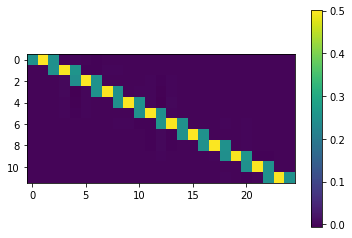

In [11]:
plt.imshow(GLOBALR)
plt.colorbar()

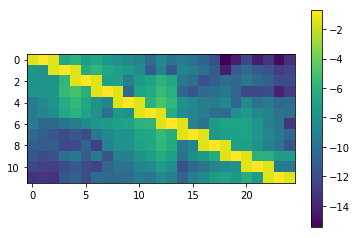

In [12]:
plt.imshow(np.log(np.abs(GLOBALR)))
plt.colorbar()

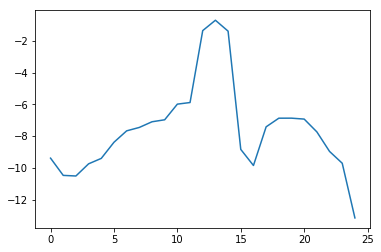

In [13]:
plt.plot(np.log(np.abs(GLOBALR[int(outputsize/2)][:])))

Energy norm: 
4.863750821932582
L2 norm: 
0.5695628309704306
H1 norm: 
3.56214910755873
Energy norm: 
0.3915018776282803
L2 norm: 
0.8054834801819976
H1 norm: 
0.4041915319616288
0.28065004414279443


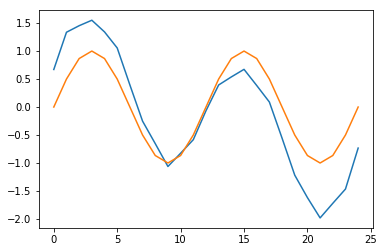

In [25]:
Xfine = np.linspace(0,1,inputsize)
Xcoarse = np.linspace(0,1,outputsize)
Mediafine = a(Xfine)
Mediacoarse = a(Xcoarse)
Urealfine = u_real(Xfine).reshape([inputsize,1])
Urealcoarse = u_real(Xcoarse).reshape([outputsize,1])
GLOBALA = np.zeros([outputsize,outputsize])

for i in range(outputsize):
    for j in range(outputsize):
        basisi = GLOBALR[i][:]
        basisj = GLOBALR[j][:]
        gxbasisi = np.gradient(basisi,h)
        gxbasisj = np.gradient(basisj,h)
        GLOBALA[i][j] = (np.sum(Mediafine*gxbasisi*gxbasisj))*(H)
        
GLOBALF = np.zeros([outputsize,1])
F = rightf(Xfine)
for j in range(outputsize):
        basisj = GLOBALR[j][:]
        GLOBALF[j][0] = (np.sum(F*basisj))*(H)
        
GLOBALU = np.linalg.solve(GLOBALA,GLOBALF)
GlobalU = np.zeros([inputsize,1])
for i in range(outputsize):
    GlobalU = GlobalU + GLOBALU[i]*GLOBALR[i][:].reshape([inputsize,1])
    
deltaU = GlobalU - Urealfine    
Mediafine = a(np.linspace(0,1,inputsize-1)).reshape([inputsize-1,1])
energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.diff(Urealfine,axis=0)/h,np.diff(Urealfine,axis=0)/h),Mediafine)*(h)))
l2norm = np.sqrt((np.sum((Urealfine)**2)*(h)))
h1norm = np.sqrt((np.sum((Urealfine)**2)*(h))+(np.sum((np.diff(Urealfine,axis=0)/h)**2)*(h)))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.diff(deltaU,axis=0)/h,np.diff(deltaU,axis=0)/h),Mediafine)*(h))))
print('L2 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))))
print('H1 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))+(np.sum((np.diff(deltaU,axis=0)/h)**2)*(h))))


print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.diff(deltaU,axis=0)/h,np.diff(deltaU,axis=0)/h),Mediafine)*(h)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h)))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))+(np.sum((np.diff(deltaU,axis=0)/h)**2)*(h)))/h1norm)
print(Rhonew)

plt.plot(GlobalU)
plt.plot(Urealfine)

Energy norm: 
21.784946868991497
L2 norm: 
1.0641593651911556
H1 norm: 
15.68710137394578
Energy norm: 
1.7573845010727138
L2 norm: 
1.5049486067796758
H1 norm: 
1.7838546276734348
0.31971478412833054


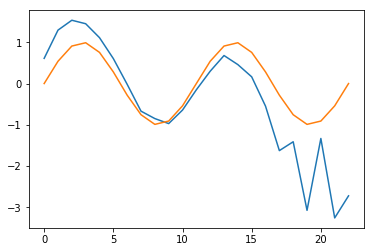

In [26]:
outputsize = np.size(LOCALR,0)
inputsize = np.size(LOCALR,1)
Xfine = np.linspace(0,1,inputsize)
Xcoarse = np.linspace(0,1,outputsize)
Mediafine = a(Xfine)
Mediacoarse = a(Xcoarse)
Urealfine = u_real(Xfine).reshape([inputsize,1])
Urealcoarse = u_real(Xcoarse).reshape([outputsize,1])
h = 1/(inputsize-1)
H = 1/(outputsize-1)
LOCALA = np.zeros([outputsize,outputsize])
for i in range(outputsize):
    for j in range(outputsize):
        basisi = LOCALR[i][:]
        basisj = LOCALR[j][:]
        gxbasisi = np.gradient(basisi,h)
        gxbasisj = np.gradient(basisj,h)
        LOCALA[i][j] = (np.sum(Mediafine*gxbasisi*gxbasisj))*(H)
        
LOCALF = np.zeros([outputsize,1])
F = rightf(Xfine)
for j in range(outputsize):
        basisj = LOCALR[j][:]
        LOCALF[j][0] = (np.sum(F*basisj))*(H)
        
LOCALU = np.linalg.solve(LOCALA,LOCALF)
LocalU = np.zeros([inputsize,1])
for i in range(outputsize):
    LocalU = LocalU + LOCALU[i]*LOCALR[i][:].reshape([inputsize,1])
    
deltaU = LocalU - Urealfine    

Mediafine = a(np.linspace(0,1,inputsize-1)).reshape([inputsize-1,1])
energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.diff(Urealfine,axis=0)/h,np.diff(Urealfine,axis=0)/h),Mediafine)*(h)))
l2norm = np.sqrt((np.sum((Urealfine)**2)*(h)))
h1norm = np.sqrt((np.sum((Urealfine)**2)*(h))+(np.sum((np.diff(Urealfine,axis=0)/h)**2)*(h)))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.diff(deltaU,axis=0)/h,np.diff(deltaU,axis=0)/h),Mediafine)*(h))))
print('L2 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))))
print('H1 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))+(np.sum((np.diff(deltaU,axis=0)/h)**2)*(h))))


print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.diff(deltaU,axis=0)/h,np.diff(deltaU,axis=0)/h),Mediafine)*(h)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h)))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.sum((deltaU)**2)*(h))+(np.sum((np.diff(deltaU,axis=0)/h)**2)*(h)))/h1norm)


print(current_rho)

plt.plot(LocalU)
plt.plot(Urealfine)